<a href="https://colab.research.google.com/github/evril7490/test/blob/master/Classification_EDA_ModelValuation_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install pdpbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve,confusion_matrix,precision_recall_curve
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import log_loss
from pdpbox import pdp
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
font_size = 15
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

In [4]:
#### Explore Continuous variable

In [5]:
def explor_categorical_plots(train_df,
                             feat_cols,
                             target_col,
                             target_col_mapname=['Retained', 'Churned'],
                             colors = ['#00A5E0', '#DD403A'],
                             ):
  colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', 
                '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
  for feat_col in feat_cols:    
    fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
    sns.countplot(x=target_col, data=train_df, palette=colors_cat,ax=ax0)
    ax0.set_ylabel('Count')
    sns.countplot(x=feat_col,
                  hue=target_col,
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    if target_col_mapname:
      ax1.legend(labels=target_col_mapname)
    sns.barplot(x=feat_col,
                y=target_col,
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    plt.tight_layout();

In [6]:
# general hist plot
def plot_continuous_for_classification(data,
                    feat_col,
                    target_col,
                    target_col_mapname=['Retained', 'Churned'],
                    colors = ['#00A5E0', '#DD403A'],
                    ):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = data.copy()
    df_retained = df_func[df_func[target_col]==0]
    df_churned  = df_func[df_func[target_col]==1]
    df_func[target_col] = df_func[target_col].astype('category')
    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})
    for df, color, label in zip([df_retained, df_churned], colors, target_col_mapname):
        sns.histplot(data=df,
                     x=feat_col,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
        ax1.legend()

    sns.boxplot(x=feat_col, y=target_col, data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    if target_col_mapname:
      ax2.set_yticklabels(target_col_mapname)
    plt.tight_layout();

def explor_continuous_plots(train_df,
                            feat_cols,
                            target_col,
                            target_col_mapname=['Retained', 'Churned'],
                            plot_cols=2,
                          ):
  #### continous variable histogram plot
  rows = (len(feat_cols)+plot_cols-1)//plot_cols
  fig, ax = plt.subplots(rows, plot_cols, figsize=(6*plot_cols, 5*rows))
  for index, column in enumerate(feat_cols):
    plt.subplot(rows, plot_cols, index + 1)
    train_df[column].hist(bins=20,
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);
    plt.title(column)
  plt.show()
  for col in feat_cols:
    plot_continuous_for_classification(train_df,col,target_col=target_col,target_col_mapname=target_col_mapname)
  #### correlation heatmap plot
  fig, ax = plt.subplots(figsize=(12, 12))
  corr = train_df[feat_cols].corr()
  np.fill_diagonal(corr.values, np.nan)
  sns.heatmap(corr,
            #annot=True,
            #annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

  ax.tick_params(axis='x', rotation=45)
  ax.tick_params(axis='y', rotation=360);

In [7]:
### Fill Na for categorical columns and continuous columns
def fill_na(df,category_cols=[], cont_cols=[],
            fill_category_value='unknown',
            fill_na_dict=None):
  X = df.copy()
  if not fill_na_dict:# we have not provided the fill_missing_dict
    fill_na_dict = {}
    for col in category_cols:
      fill_na_dict[col] = fill_category_value

    for col in cont_cols:
      fill_na_dict[col] = X[col].mean()

  for feat_col,fill_value in fill_na_dict.items():
    X[feat_col].fillna(fill_value,inplace=True)

  return X,fill_na_dict


def target_encoder(df,feat_cols,target_col,post_fix='_TE',target_encode_dict=None):
  df = df.copy()
  if not target_encode_dict:
    target_encode_dict = {}
    for col in feat_cols:
      target_encode_dict[col] = dict(df.groupby(col)[target_col].mean())
  for col in feat_cols:
    df[f'{col}{post_fix}'] = df[col].map(target_encode_dict[col])
  
  return df,target_encode_dict

def one_hot_encoder(df,feat_cols,enc_dict=None):
  enc_df = []
  # if enc_dict is not provided, will run the feats and create the encode dict
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = OneHotEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = enc
  
  for feat_col in feat_cols:
    enc = enc_dict[feat_col]
    enc_df.append( pd.DataFrame(enc.transform(df[[feat_col]]).toarray(),columns= [ f'{feat_col}_{k}' for k in enc.categories_[0] ],index=df.index ) )
  
  enc_df = pd.concat(enc_df,axis=1)
  for col in enc_df:
    if col in df:
      print(f'Will overwrite {col} since it already exist in df')
      df = df.drop(columns=[col])
  df = pd.concat([ df,enc_df], axis=1)
  return df,enc_dict

def label_encoder(df,feat_cols,enc_dict=None,postfix='_LE'):
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = LabelEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

  for feat_col in feat_cols:
    df[f'{feat_col}{postfix}'] = df[feat_col].map(enc_dict[feat_col])
  return df,enc_dict


def preprocess_test(test_df,preprocess_dict):
  df = test_df.copy()
  if 'fill_na_dict' in preprocess_dict:
    df,_ = fill_na(df,fill_na_dict=preprocess_dict['fill_na_dict'])

  if 'target_encode_dict' in preprocess_dict:
    feat_cols = preprocess_dict['target_encode_dict'].keys()
    df, _ = target_encoder(df,feat_cols,None,post_fix='_TE',target_encode_dict=preprocess_dict['target_encode_dict'])

  if 'one_hot_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['one_hot_enc_dict'].keys()
    df, _ = one_hot_encoder(df,feat_cols,enc_dict=preprocess_dict['one_hot_enc_dict'])
  
  if 'label_enc_dict' in preprocess_dict:
    feat_cols = preprocess_dict['label_enc_dict'].keys()
    df, _ = label_encoder(df,feat_cols,enc_dict=preprocess_dict['label_enc_dict'])
  
  return df

In [174]:
def plot_feature_imp(classifier, feat_cols):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': feat_cols,
                                'Importance': np.round(classifier.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')
    importances.plot.barh(color='cadetblue',
                          edgecolor='firebrick',
                          legend=False,
                          figsize=(16,max(4,len(feat_cols)//2))
                          )
    plt.xlabel('Importance');
    return importances

def plot_conf_mx(cm, ax,target_col_mapname=['Retained', 'Churned']):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                fmt='g',
                ax=ax)
    ax.set_xlabel('Predicted Label'); 
    ax.set_xticks([0.5, 1.5]);
    ax.set_xticklabels(target_col_mapname)
    ax.set_ylabel('True Label');
    ax.set_yticks([0.25, 1.25]);
    ax.set_yticklabels(target_col_mapname);

def clf_performance(X_train,y_train,classifier,cutoff=0.5):
    '''Display the overall performance of a classifier with this template.'''
    y_pred_pp = classifier.predict_proba(X_train)[:, 1]
    y_pred = (y_pred_pp >= cutoff).astype(int)

    cm1 = confusion_matrix(y_train, y_pred)#.round(decimals=
    cm2 = confusion_matrix(y_train, y_pred, normalize='true').round(decimals=3)
    cm3 = confusion_matrix(y_train, y_pred, normalize='pred').round(decimals=3)
    print(f'accuracy {accuracy_score(y_train, y_pred)}, precision {precision_score(y_train, y_pred)}, recall is {recall_score(y_train, y_pred)}')
    
    lr_precision, lr_recall, thres = precision_recall_curve(y_train, y_pred_pp)
    n_tp = []
    n_fp = []
    n_tn = []
    n_fn = []
    for t in thres:
      tmp_pred = (y_pred_pp >= t).astype(int)
      n_tp.append( ((tmp_pred==1)&(y_train==1)).sum() )
      n_fp.append( ((tmp_pred==1)&(y_train==0)).sum() )
      n_tn.append( ((tmp_pred==0)&(y_train==0)).sum() )
      n_fn.append( ((tmp_pred==0)&(y_train==1)).sum() )

    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(20, 5))
    ax0.plot(lr_recall, lr_precision, marker='.',alpha=.5)
    ax0.set_xlabel('Recall')
    ax0.set_ylabel('Precision')
    
    ax1.plot(thres, n_fp,label='#FP')
    ax1.plot(thres, n_tp,label='#TP')
    ax1.plot(thres, n_fn,label='#FN')
    ax1.plot(thres, n_tn,label='#TN')
    ax1.set_xlabel('Threshold')
    ax1.legend()

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20, 5))
    plot_conf_mx(cm1, ax1)
    plot_conf_mx(cm2, ax2)
    plot_conf_mx(cm3, ax3)
    plt.tight_layout();
    return (lr_precision, lr_recall, thres,n_tp,n_fp,n_tn,n_fn)


In [9]:
def parameter_search(X,
                     y,
                     estimator,
                     param_grid,
                     ):
  best_score = np.inf
  for g in ParameterGrid(param_grid):
    estimator.set_params(**g)
    estimator.fit(X,y)
    # save if best
    pred_train = np.argmax(estimator.oob_decision_function_,axis=1)
    oob_score = log_loss(y,pred_train)
    #print(oob_score,g)
    if oob_score < best_score:
        best_score = oob_score
        best_grid = g
  estimator.set_params(**best_grid)
  estimator.fit(X,y)
  print(f"OOB best: {best_score:.4f} and para is {best_grid}") 
  return estimator

def get_best_precision_recall(lr_precision, lr_recall, threshold, precision=True,value=0.5):
  ''' Given the minimum value needed for precision or recall, return the best we could achive for the other parameter and corresponding threshold'''
  if precision:
    ind = min([i for i,val in enumerate(lr_precision) if val>=value])
    print(f'Given we want at least {value} for precision, the best recall we could get is {lr_recall[ind]:.3f} and threshold is {threshold[ind]:.3f}')
    return threshold[ind], lr_recall[ind]
  else:
    ind = max([i for i,val in enumerate(lr_recall) if val>=value])
    print(f'Given we want at least {value} for recall, the best precision we could get is {lr_precision[ind]:.3f} and threshold is {threshold[ind]:.3f}')
    return threshold[ind], lr_precision[ind]

def plot_pdp(x,m,feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns,feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [10]:
def upload_to_colab():
  from google.colab import files 
  import io
  uploaded = files.upload()
  f = list(uploaded.keys())[0]
  df = pd.read_csv(io.StringIO(uploaded[f].decode('utf-8')))
  return df

In [11]:
df_raw = upload_to_colab()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [13]:
df_raw.head()

RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

In [14]:
df=df_raw.drop(columns=['RowNumber','CustomerId','Surname'])

In [15]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 1)

In [16]:
train_df['Geography'].value_counts()

France     3994
Germany    2030
Spain      1976
Name: Geography, dtype: int64

In [ ]:
#### EDA

In [19]:
TARGET='Exited'
target_col_mapname = ['Retain','Churn']

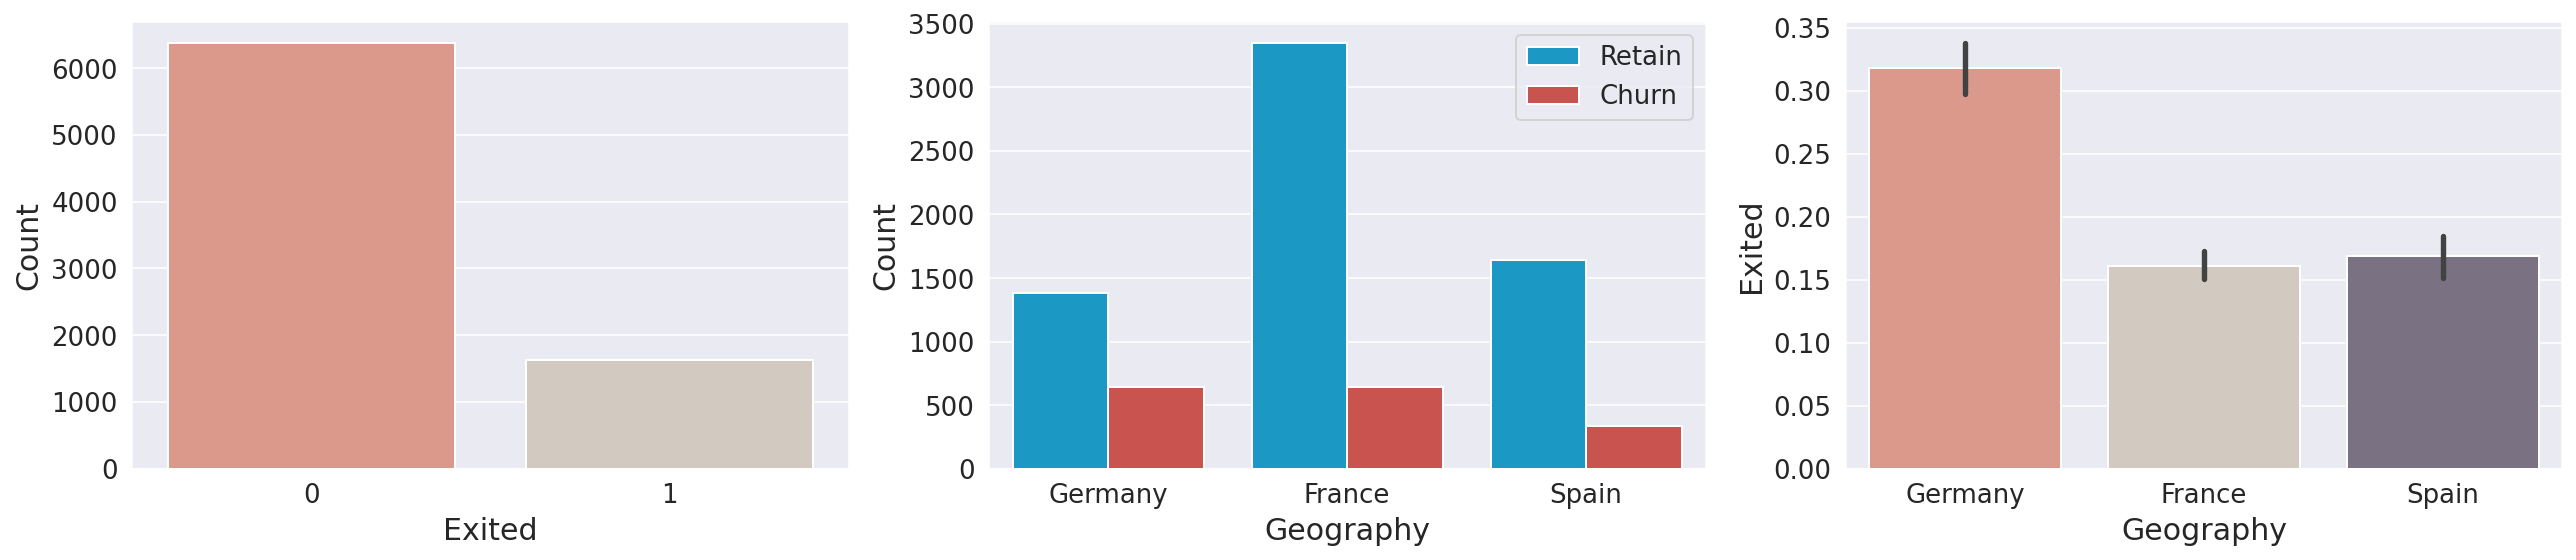

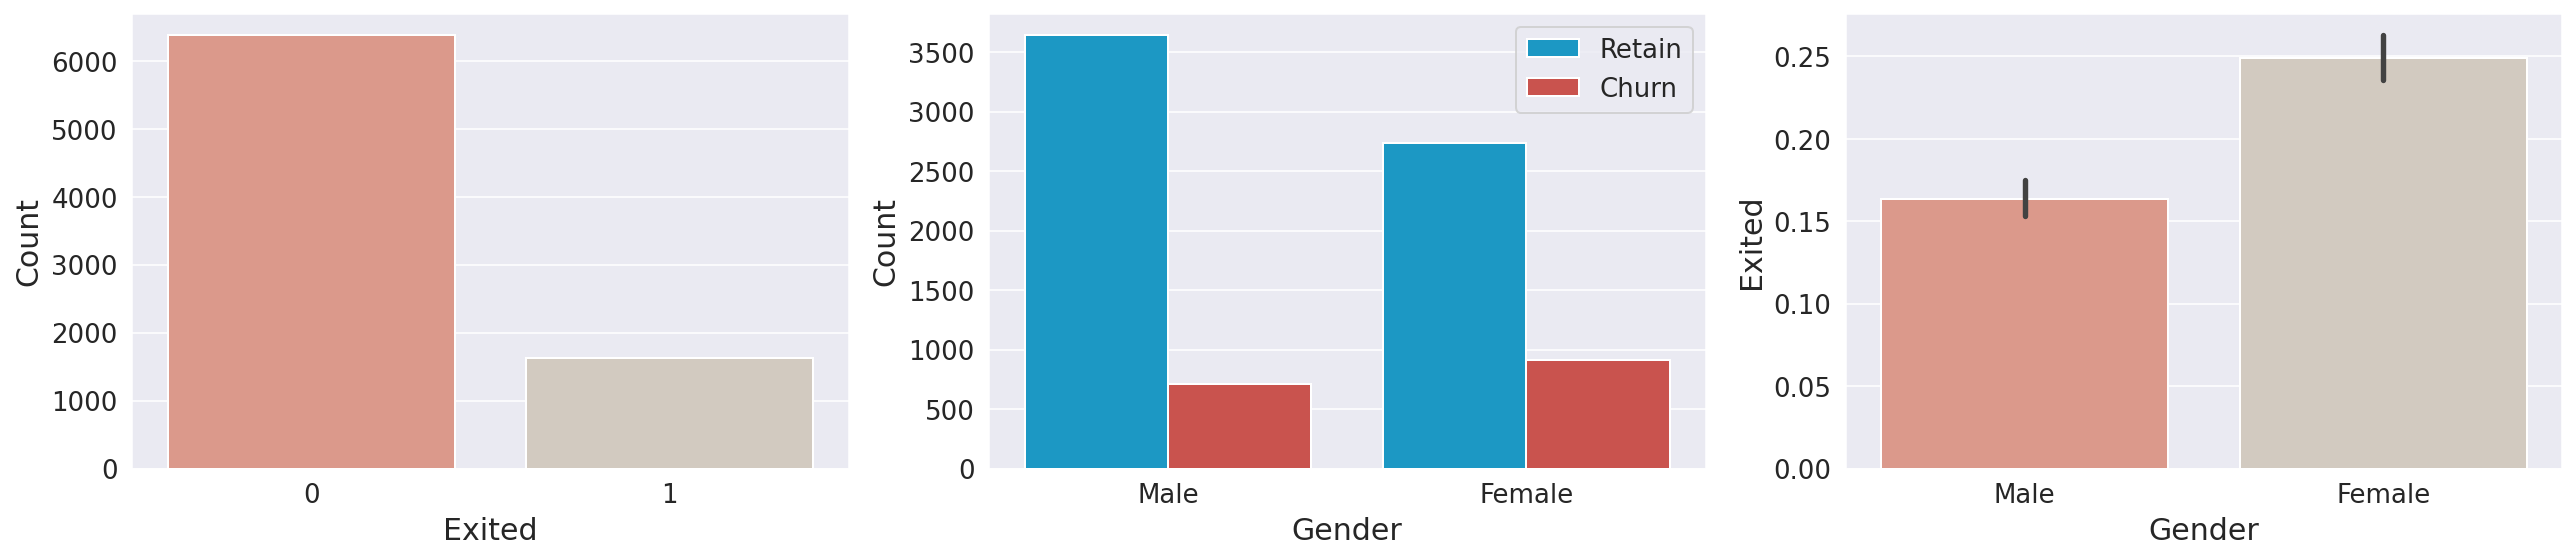

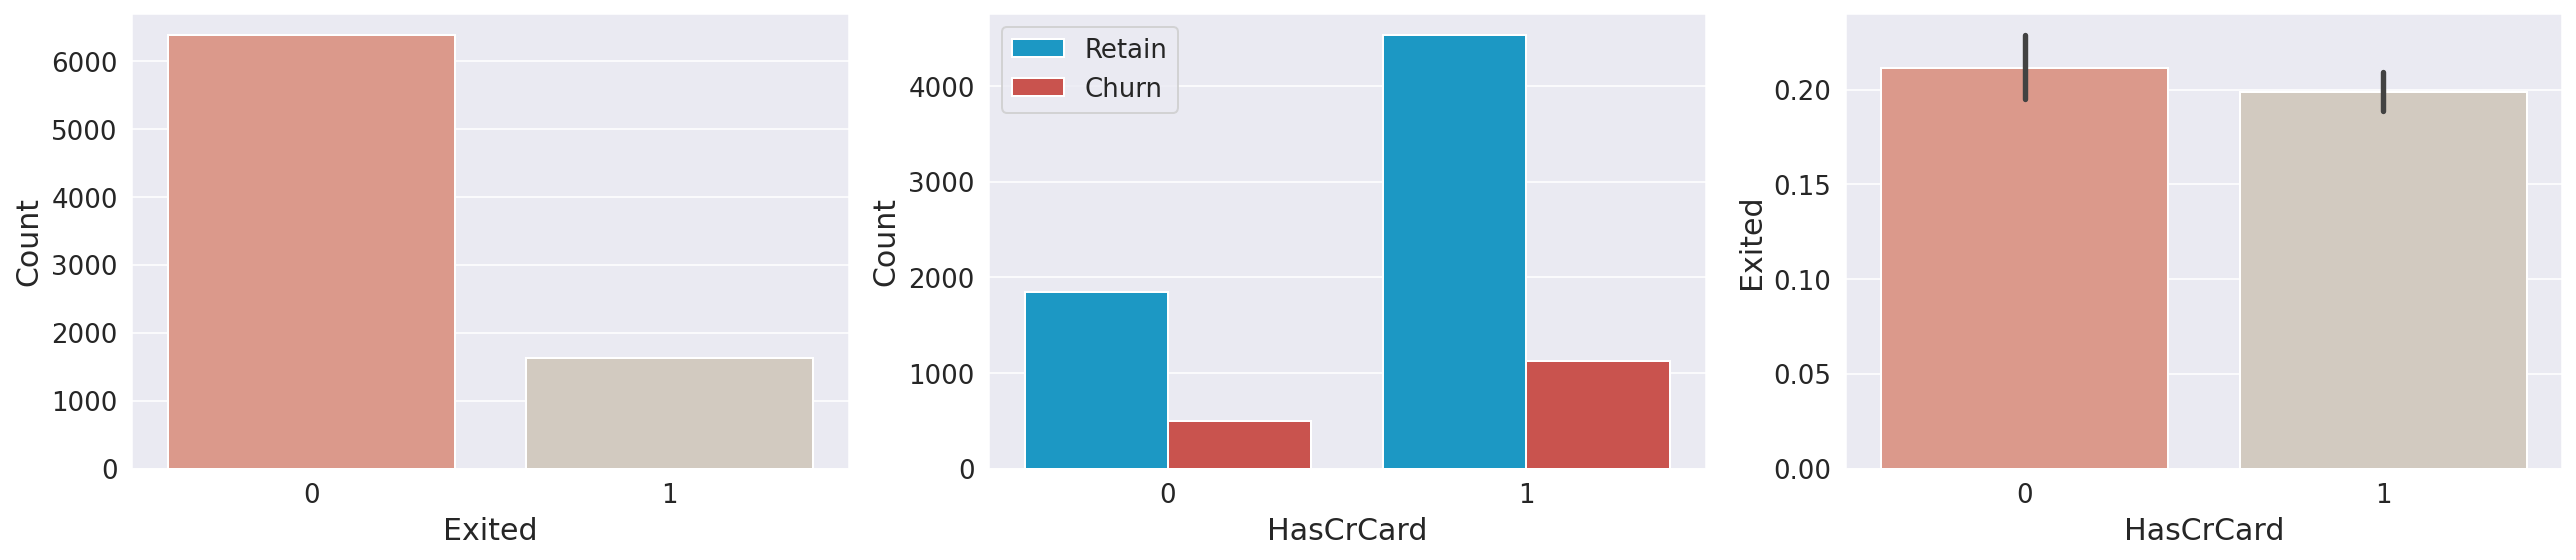

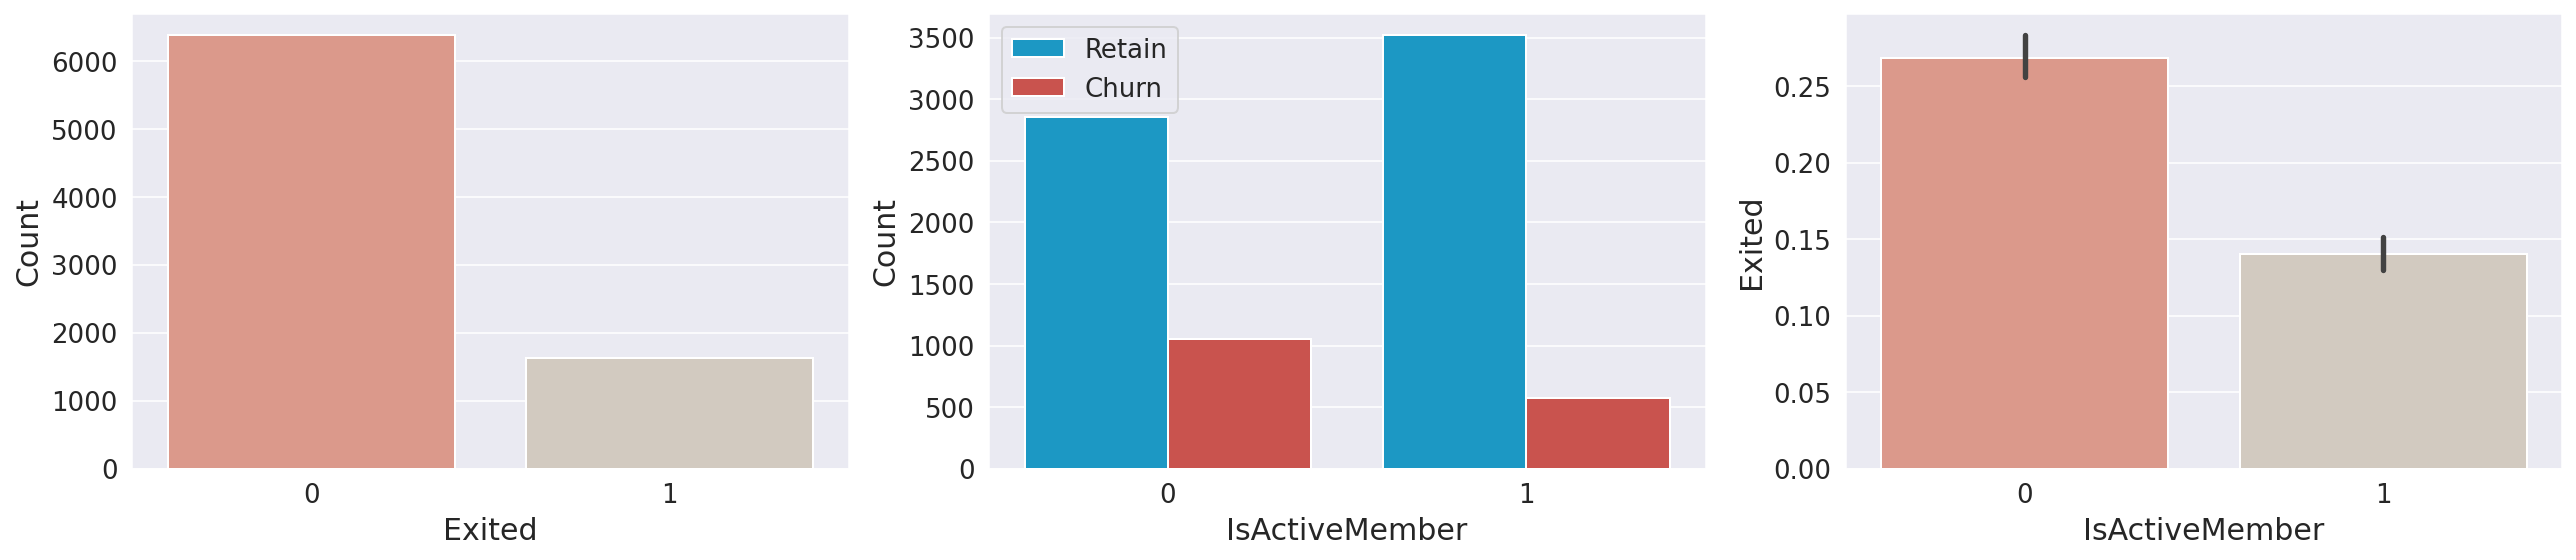

In [20]:
explor_categorical_plots(train_df,
                         feat_cols=['Geography','Gender','HasCrCard','IsActiveMember'],
                         target_col=TARGET,
                         target_col_mapname=target_col_mapname
                         )

In [21]:
numeric_cols = list(train_df.select_dtypes(include=[np.number]).columns)

for col in ['HasCrCard','IsActiveMember','Exited']:
  numeric_cols.remove(col)

print(numeric_cols)


['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


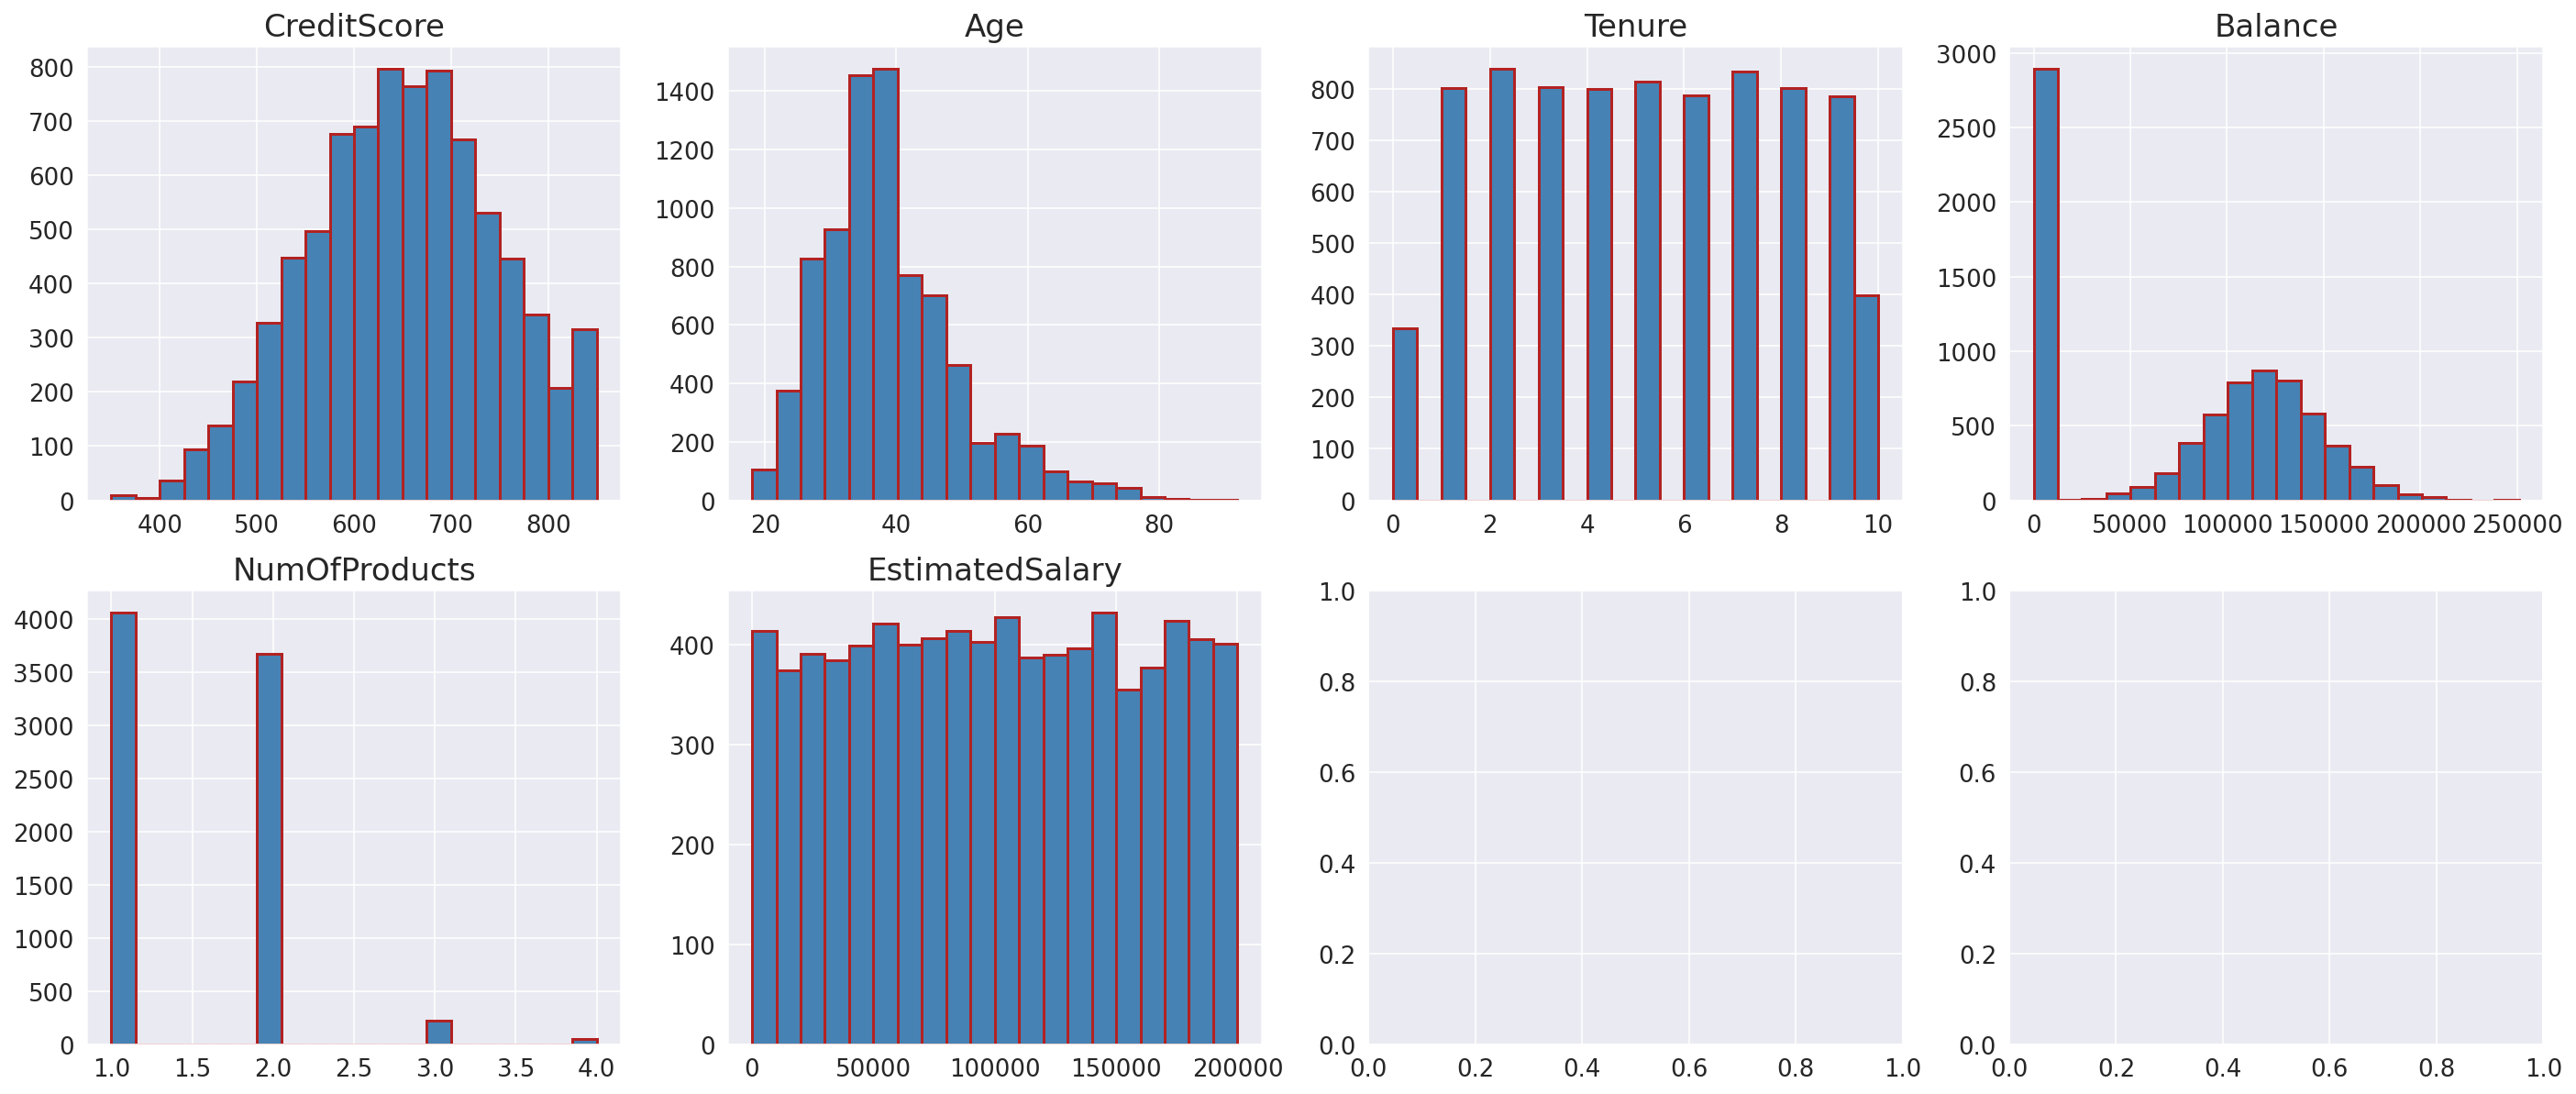

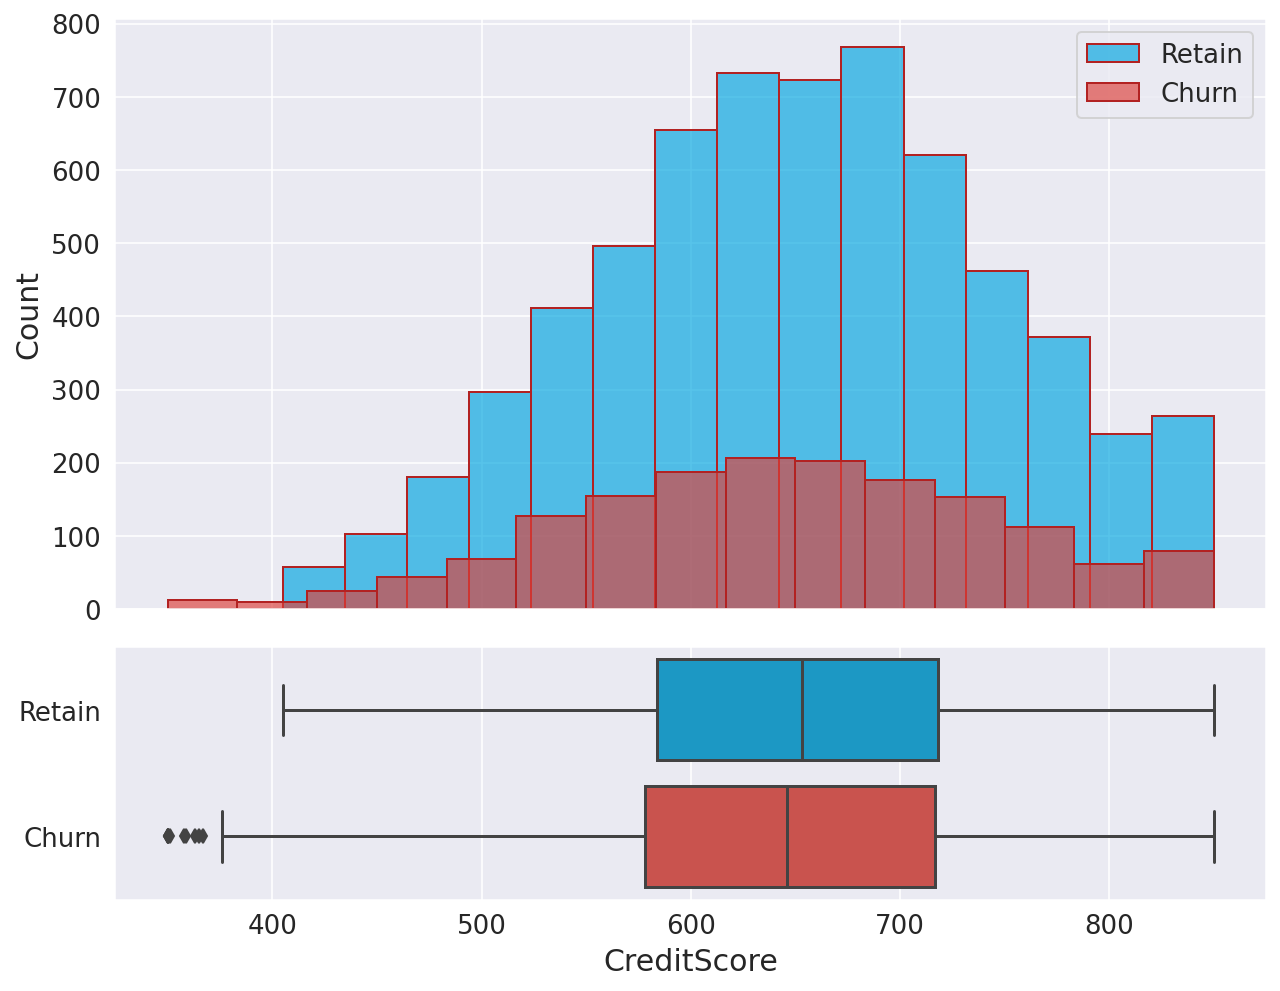

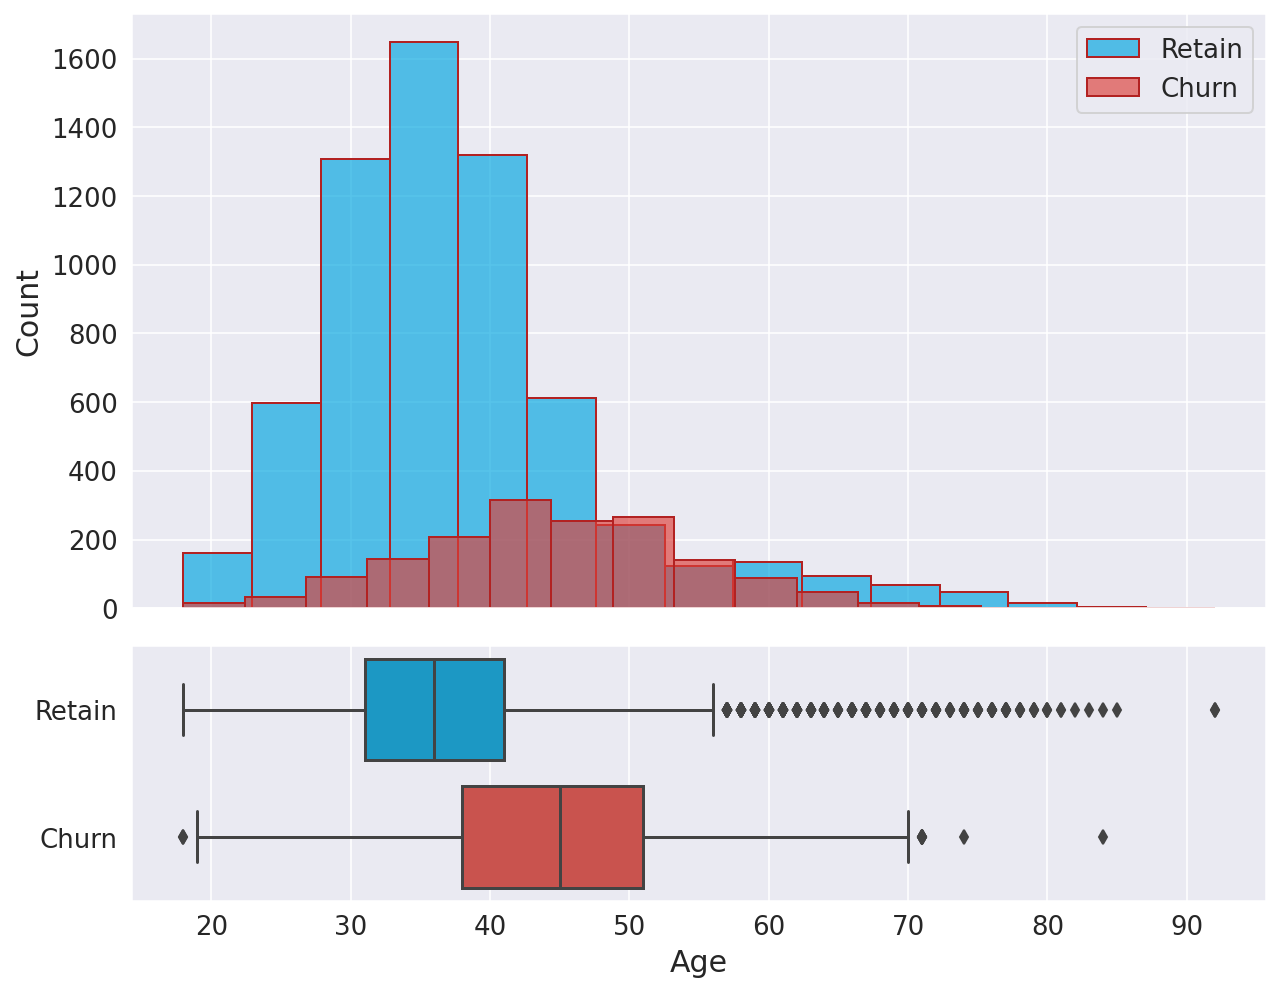

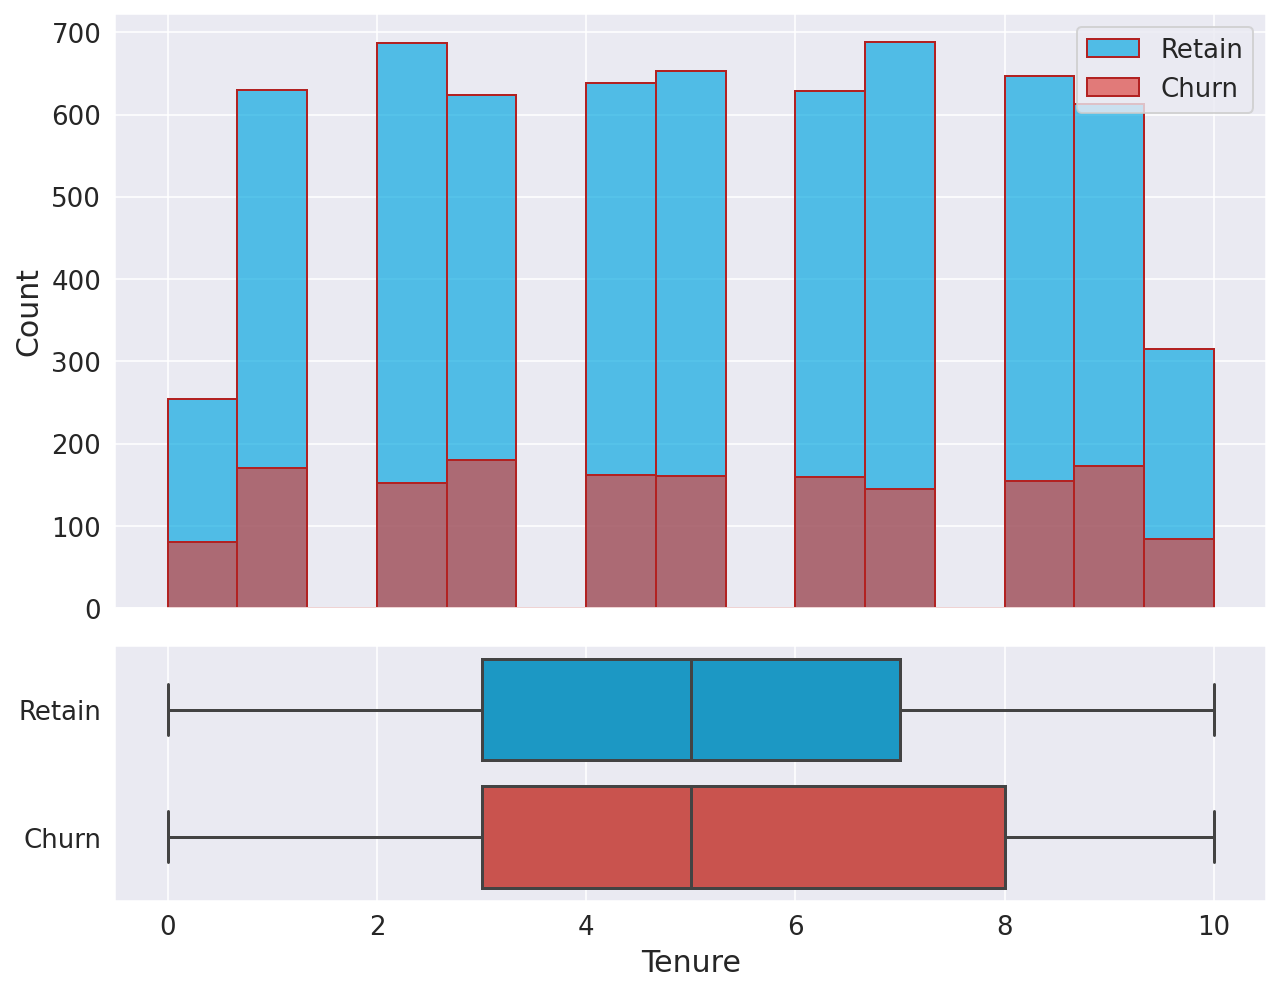

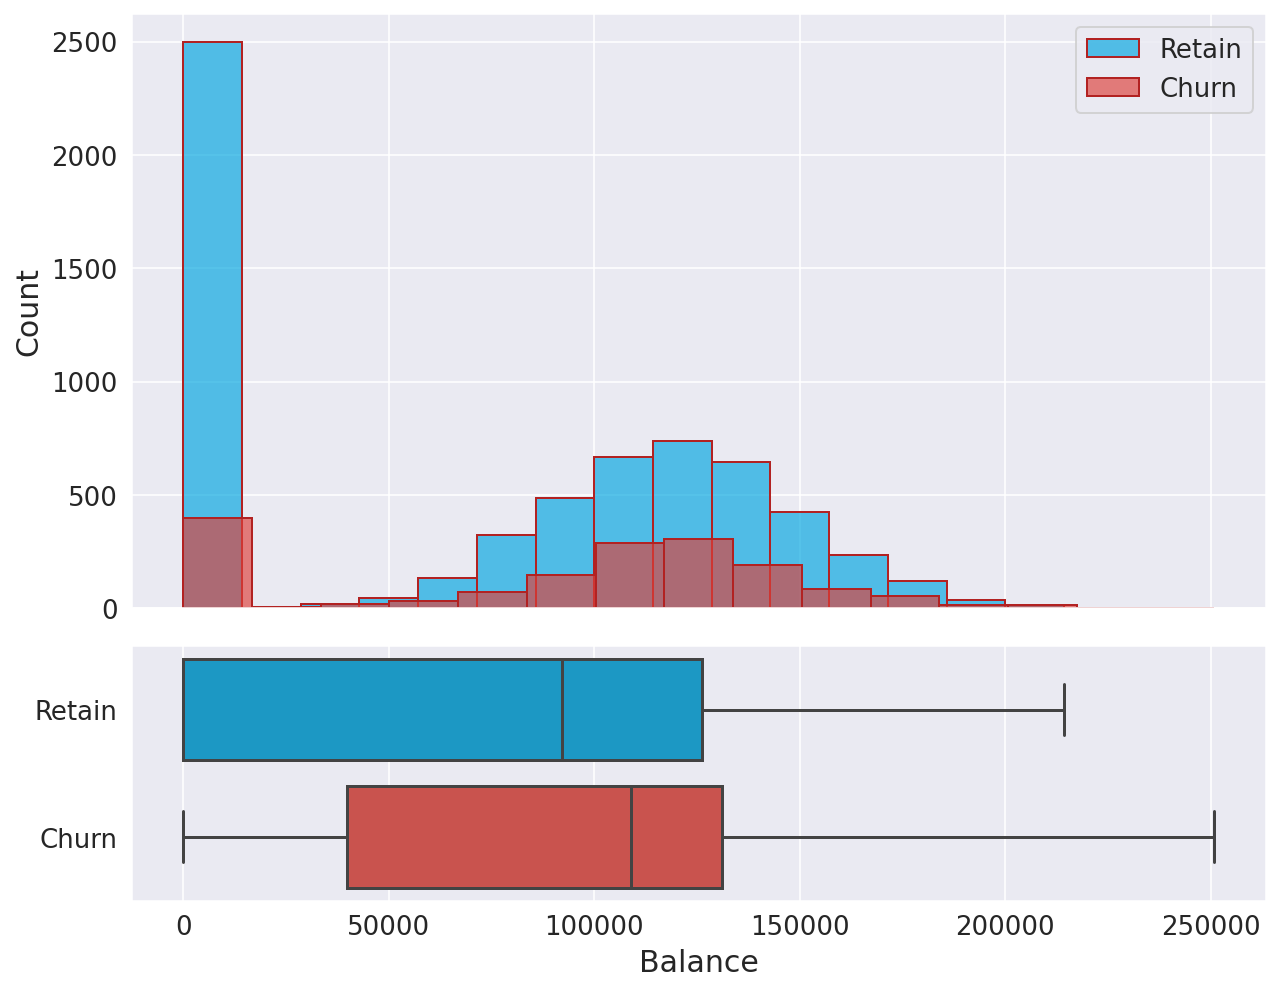

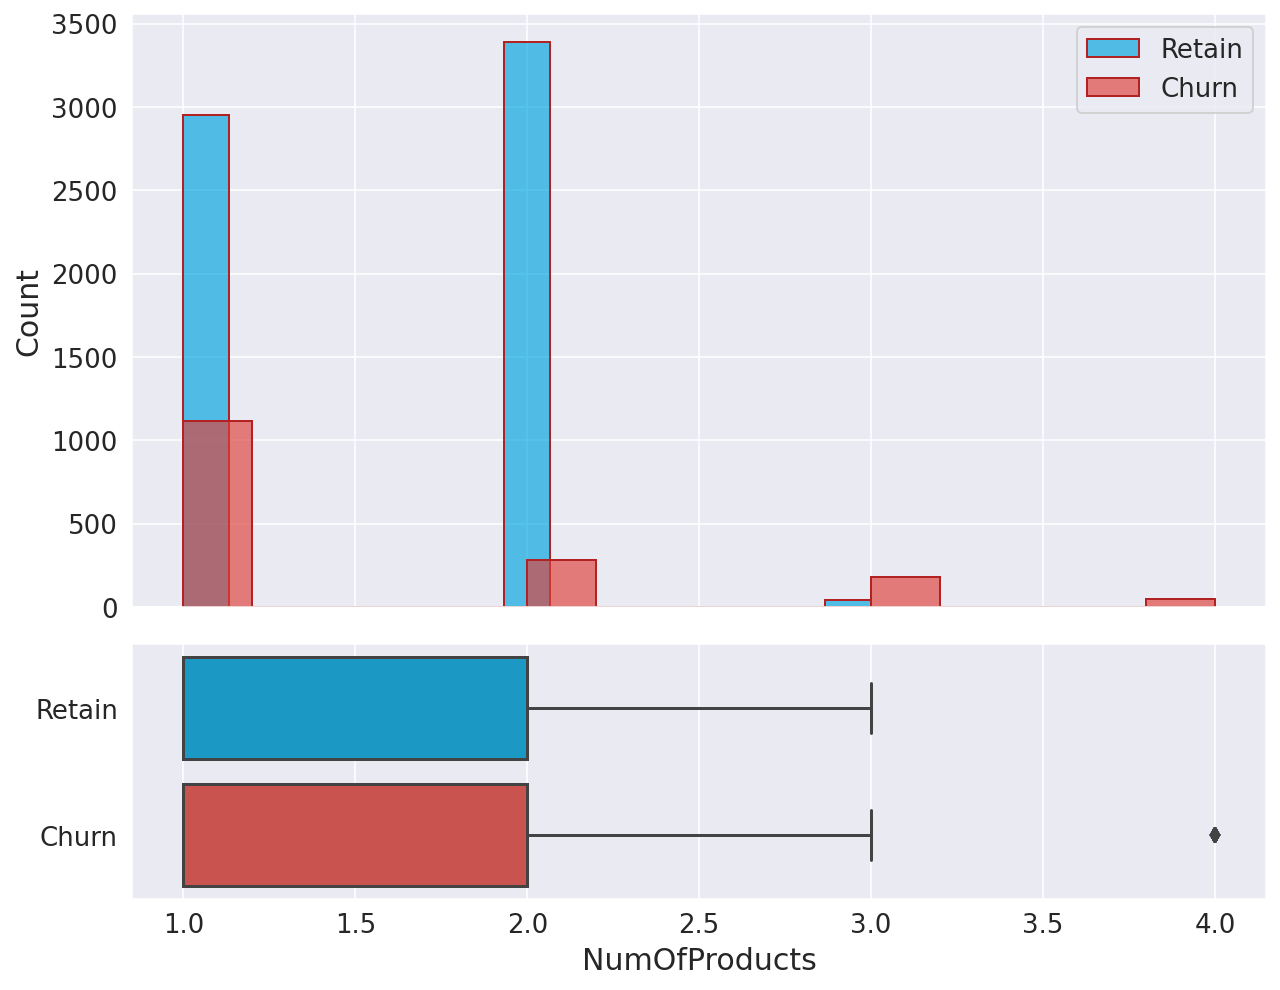

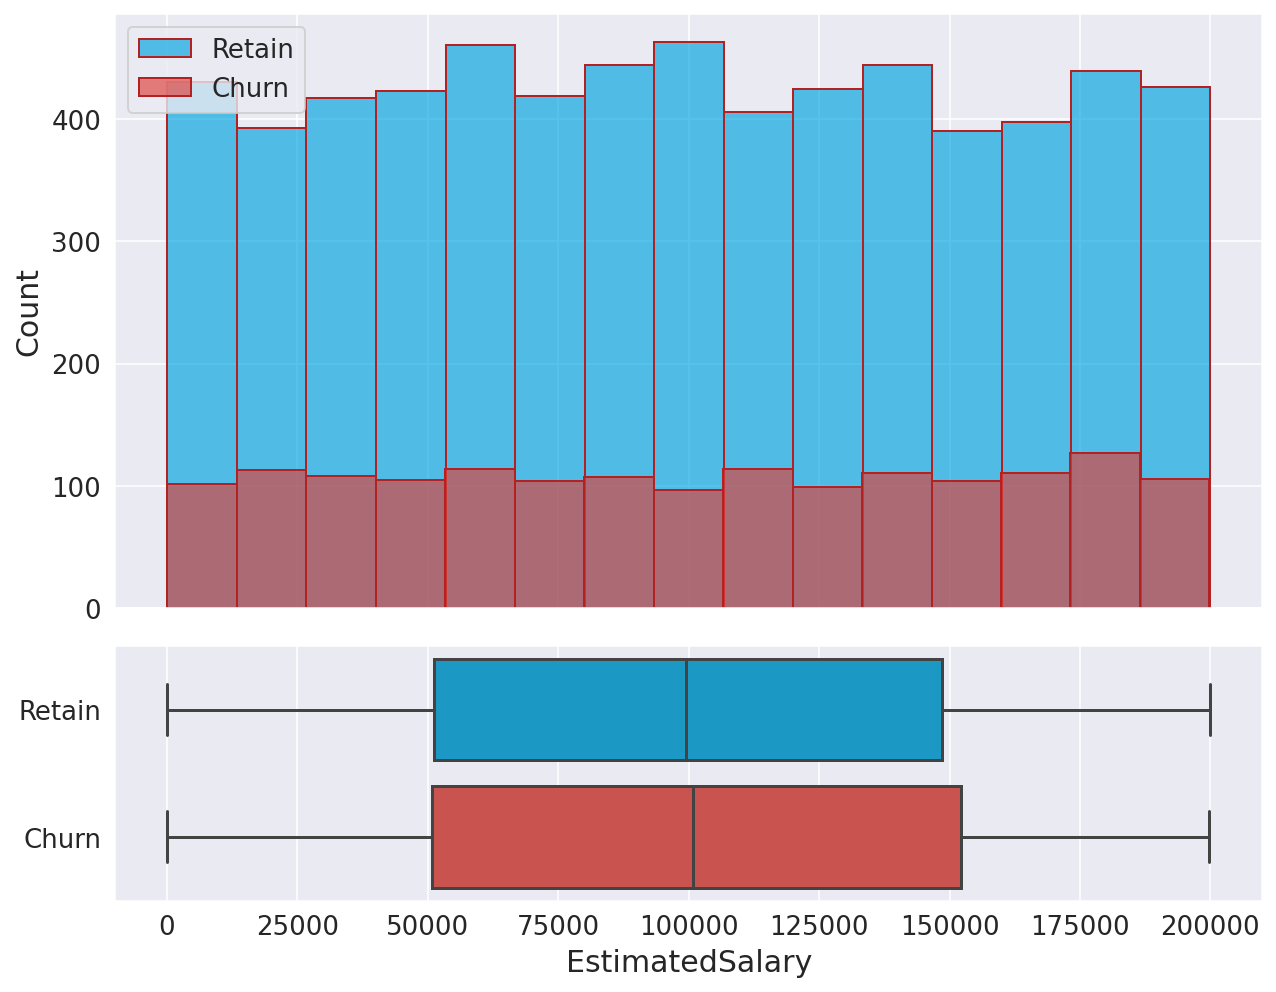

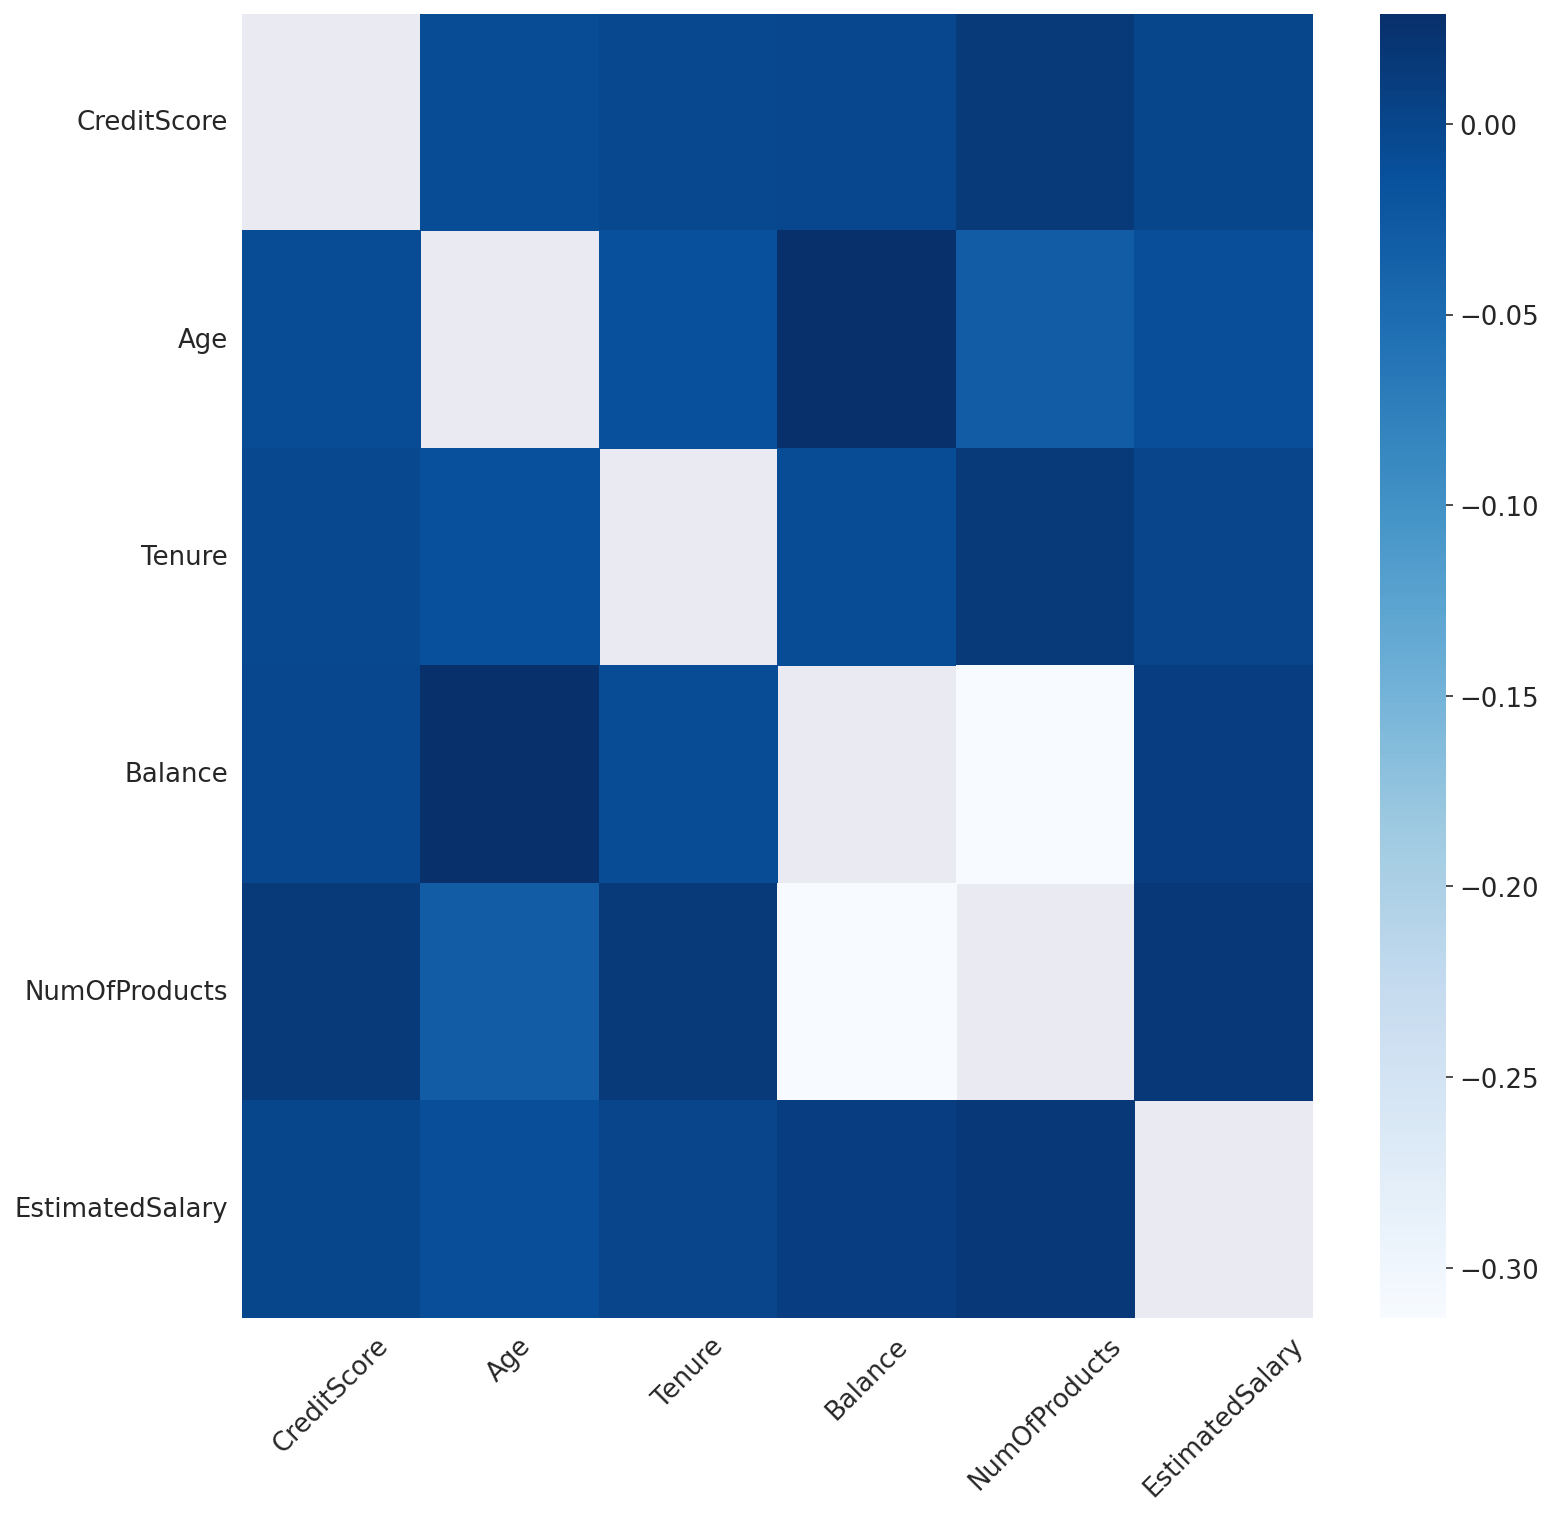

In [22]:
explor_continuous_plots(train_df,
                        numeric_cols,
                        target_col=TARGET,
                        target_col_mapname=target_col_mapname,
                        plot_cols=4)

In [ ]:
#### Data preprocess

In [24]:
preprocess_dict = {}
train_df,fill_na_dict =fill_na(train_df,
                                 category_cols        =[],
                                 cont_cols            =[],
                                 fill_category_value  ='unknown',
                              )
print(fill_na_dict)
preprocess_dict['fill_na_dict'] = fill_na_dict 

{}


In [25]:
train_df,target_encode_dict = target_encoder(train_df,[],target_col=TARGET,post_fix='_TE')
preprocess_dict['target_encode_dict']= target_encode_dict 

In [26]:
# train_df['Area_Code']=train_df['Area_Code'].astype(str)
train_df,one_hot_enc_dict = one_hot_encoder(train_df,feat_cols=['Geography'])
preprocess_dict['one_hot_enc_dict']= one_hot_enc_dict

In [27]:
train_df,label_enc_dict = label_encoder(train_df,feat_cols=['Gender'],postfix='_LE')
preprocess_dict['label_enc_dict']= label_enc_dict

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
train_df.head()

CreditScore Geography  ... Geography_Spain  Gender_LE
2694          628   Germany  ...             0.0          1
5140          626    France  ...             0.0          0
2568          612   Germany  ...             0.0          0
3671          646   Germany  ...             0.0          0
7427          714     Spain  ...             1.0          1

[5 rows x 15 columns]

In [29]:
train_df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_LE'],
      dtype='object')

In [30]:
feats= ['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_LE'
       ]

In [ ]:
#### Train model 
#### This step is to get optiaml parameters and feature importance to select the approraite features in the final model

In [32]:
rf = RandomForestClassifier(random_state=42,oob_score=True,class_weight='balanced',n_jobs=-1,bootstrap=True)
param_grid = {
    'n_estimators': [100,300],
    'criterion': ['entropy', 'gini'],
    'max_depth': [4,8],
    'max_features': [0.5, 0.8],
    'min_samples_leaf': [5,11],
    'min_samples_split': [5,11,19],
}
best_rf_clf = parameter_search(train_df[feats].values, 
                               train_df[TARGET].values,estimator=rf,param_grid=param_grid)             

OOB best: 6.2646 and para is {'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


accuracy 0.848, precision 0.5952157598499062, recall is 0.782367447595561


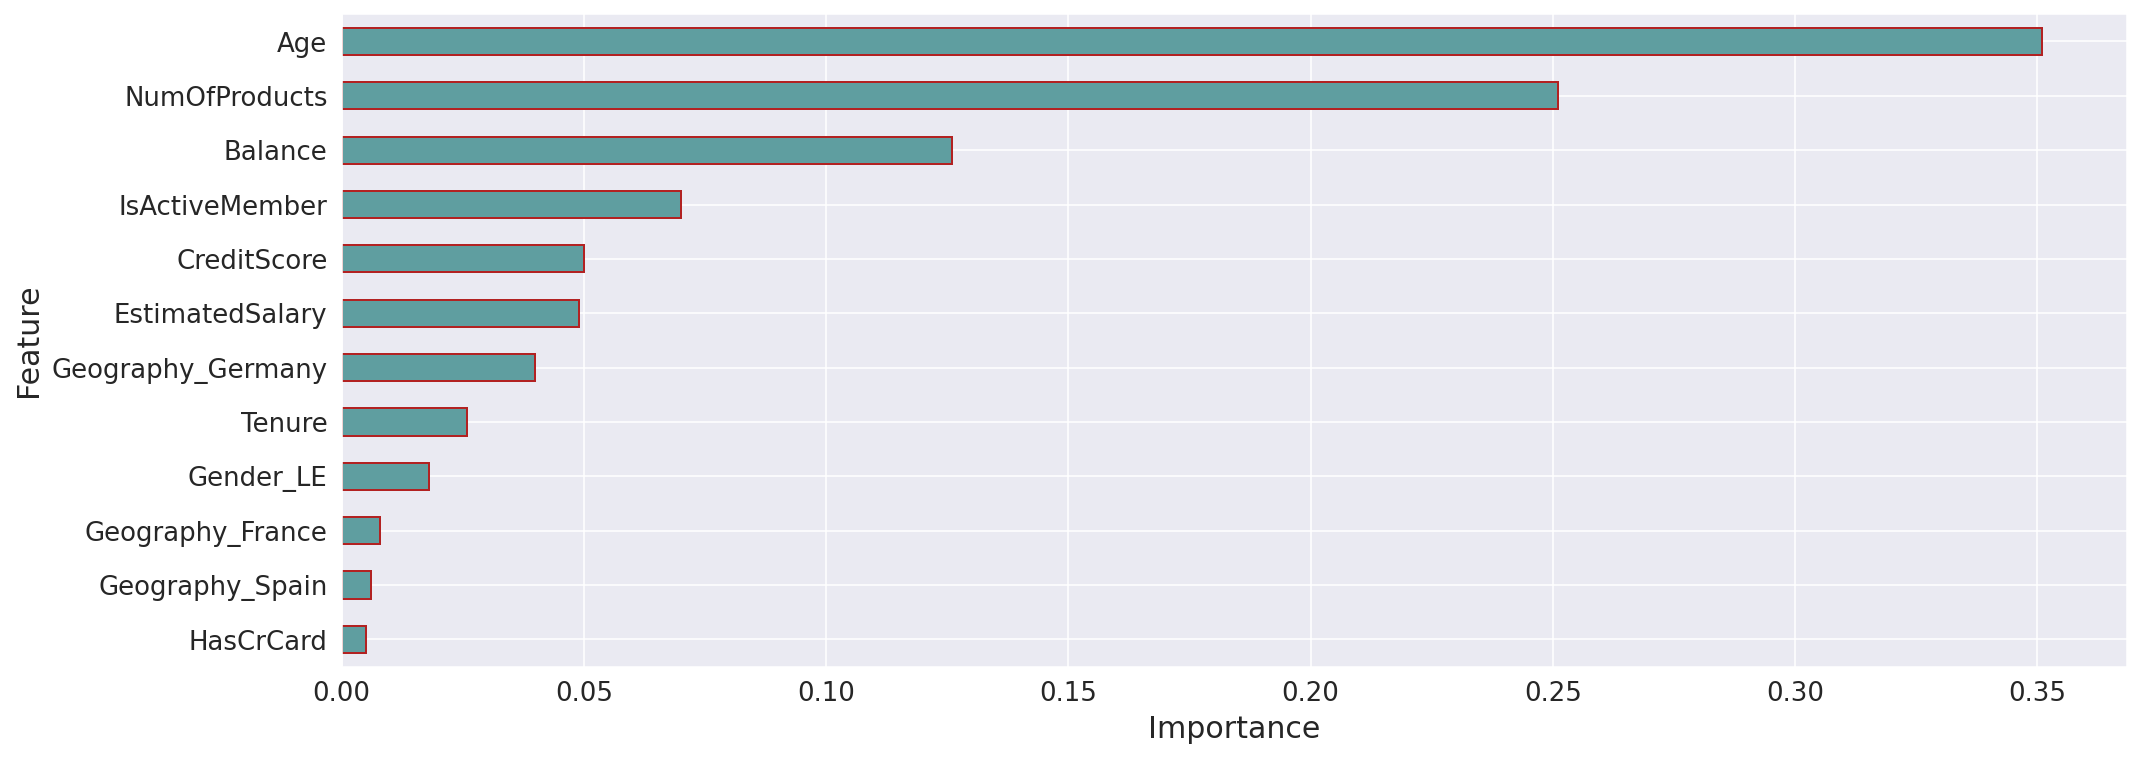

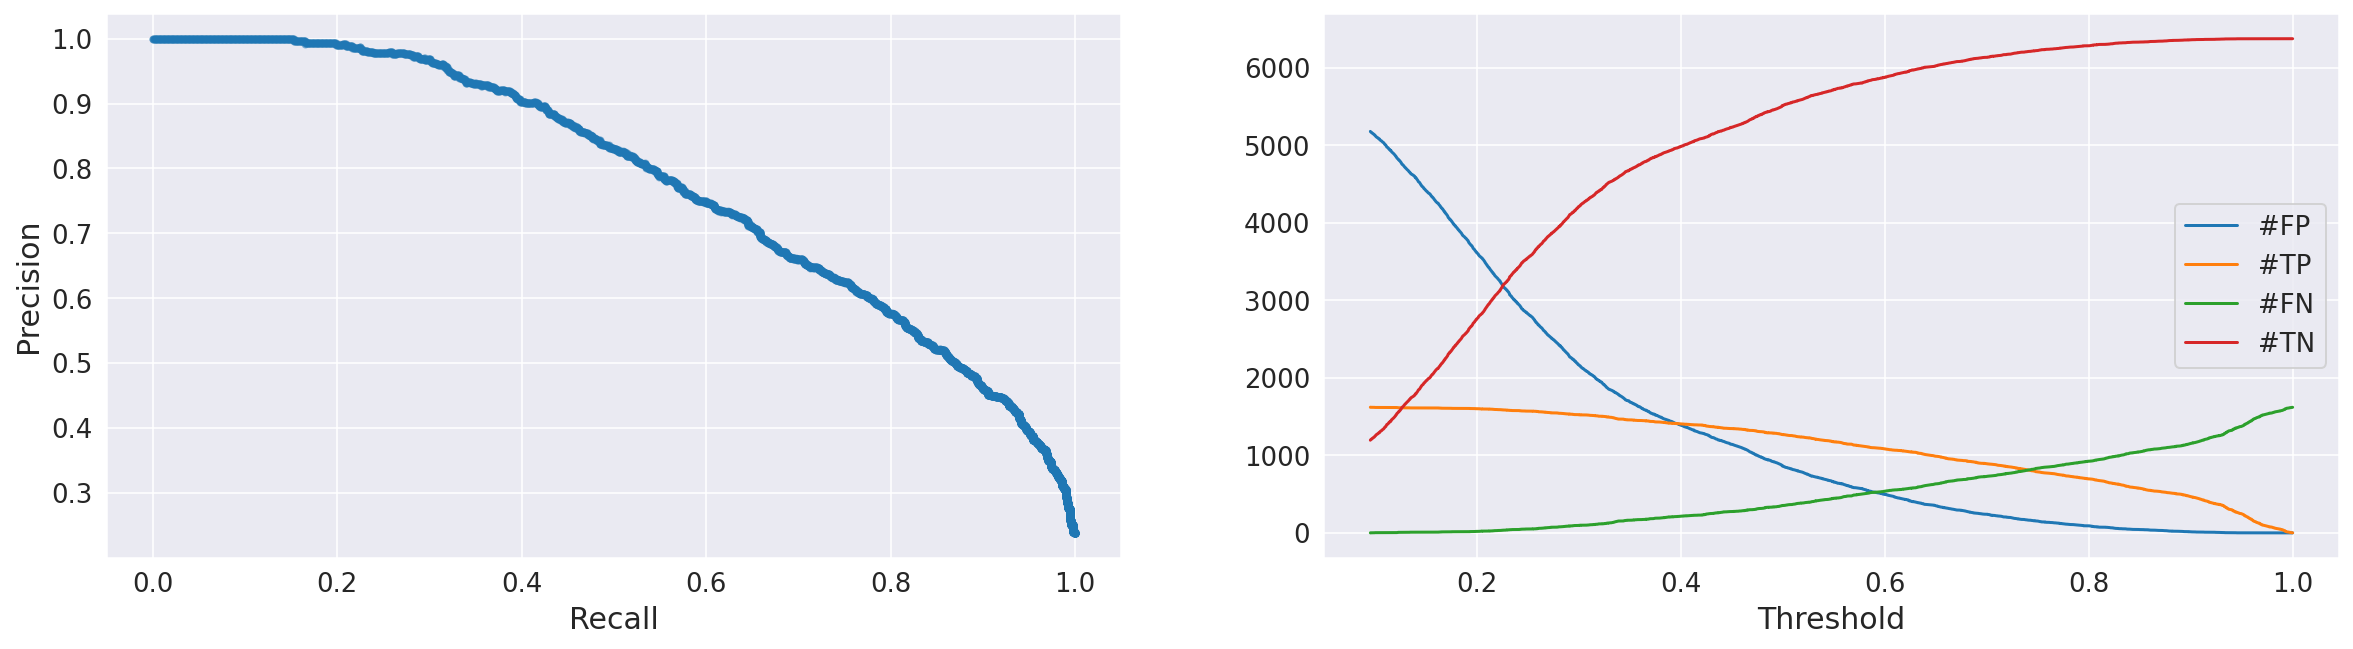

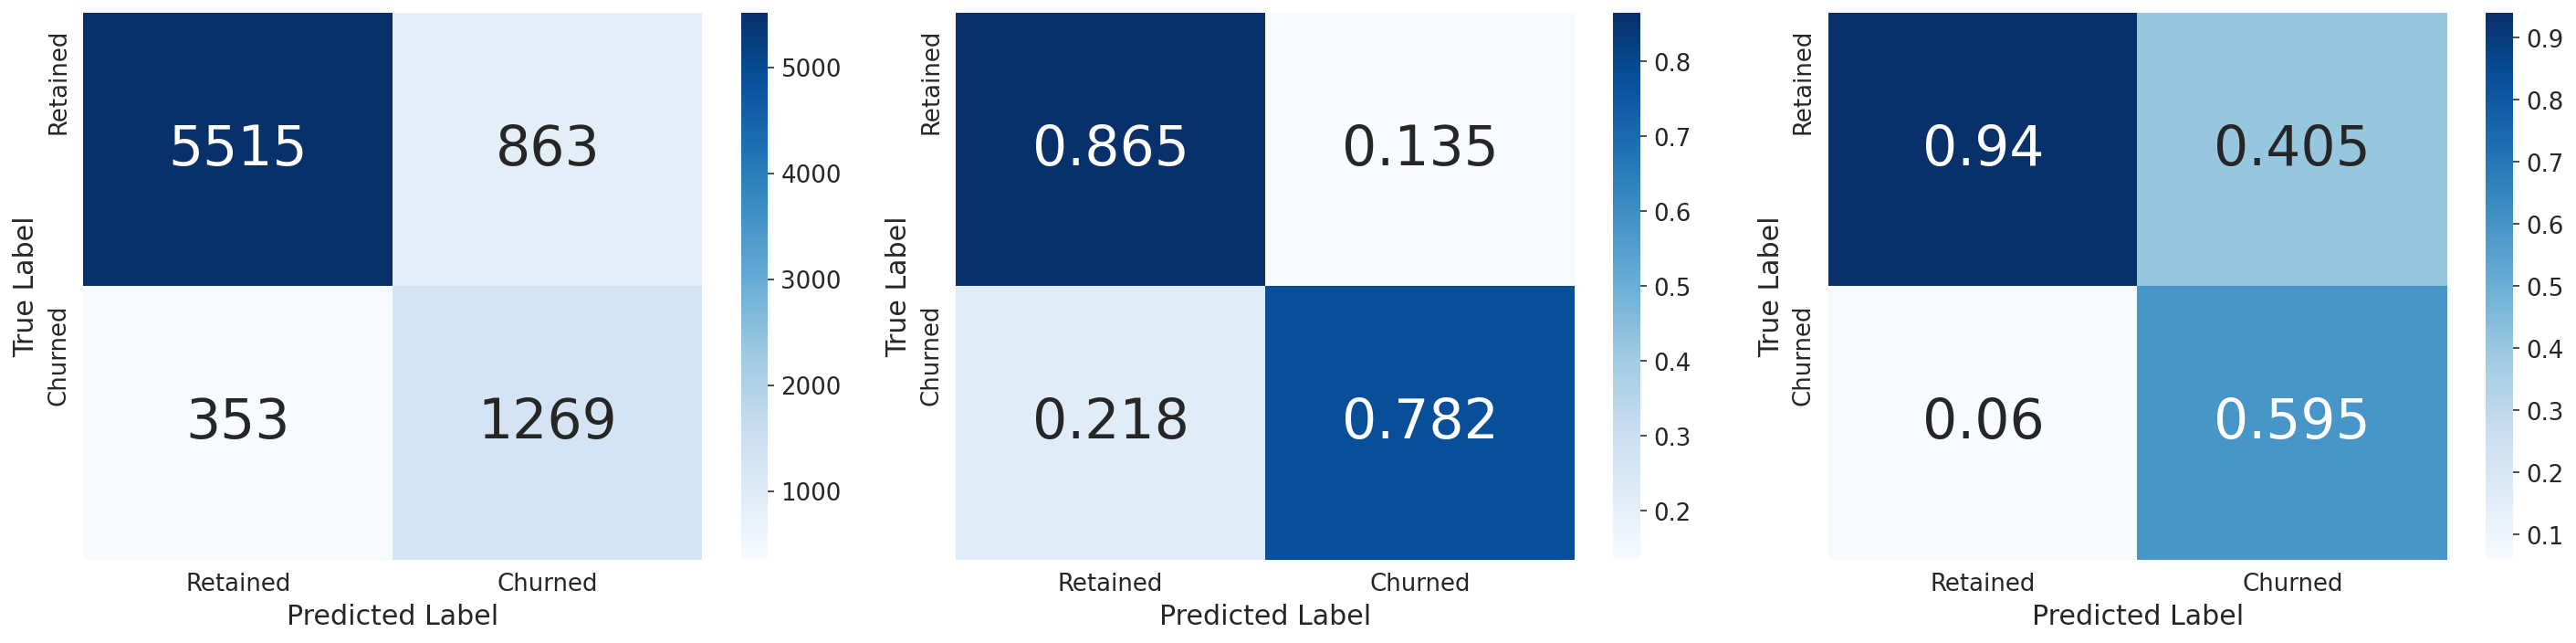

In [175]:
importances = plot_feature_imp(best_rf_clf,feats)
(lr_precision, lr_recall,thres,n_tp,n_fp,n_tn,n_fn) = clf_performance(train_df[feats].values, train_df[TARGET].values,best_rf_clf)

In [70]:
desired_threshold, best_recall    = get_best_precision_recall(lr_precision, lr_recall, threshold, precision=True,value=0.8)
desired_threshold, best_precision = get_best_precision_recall(lr_precision, lr_recall, threshold, precision=False,value=0.8)

Given we want at least 0.8 for precision, the best recall we could get is 0.538 and threshold is 0.711
Given we want at least 0.8 for recall, the best precision we could get is 0.576 and threshold is 0.483


In [165]:
def max_profit(n_tp,n_fp,n_tn,n_fn,customer_value=5000,retention_value=1000):
  ### find optiaml threshold to give retention offer
  rev = []
  for tp,fp in zip(n_tp,n_fp):
    rev.append(tp * customer_value - retention_value * (tp+fp))
  rev = np.array(rev)
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 5))
  ax1.plot(threshold,rev)
  ax1.set_title('Threshold and corresponding revenue')
  ax1.set_xlabel('Threshold')

  ax2.plot(threshold, n_fp,label='#FP')
  ax2.plot(threshold, n_tp,label='#TP')
  ax2.plot(threshold, n_fn,label='#FN')
  ax2.plot(threshold, n_tn,label='#TN')
  ax2.legend()
  ax2.set_xlabel('Threshold')
  ax2.set_title('')
  ind = rev.argmax()
  print(f'Max total revenue is {rev.max()}, corresponding mean revenue is {rev.max()/(n_fp[ind]+n_tp[ind]) :.0f} and threshold {threshold[ind]:.2f}')
  cm = np.array([[ n_tn[ind], n_fp[ind] ], [n_fn[ind],n_tp[ind]] ])
  plot_conf_mx(cm, ax3)
  ax3.set_title('Max revenue threshold confusion matrix')
  return threshold[ind]

Max total revenue is 4281000, corresponding mean revenue is 1598 and threshold 0.42


0.4209071996176325

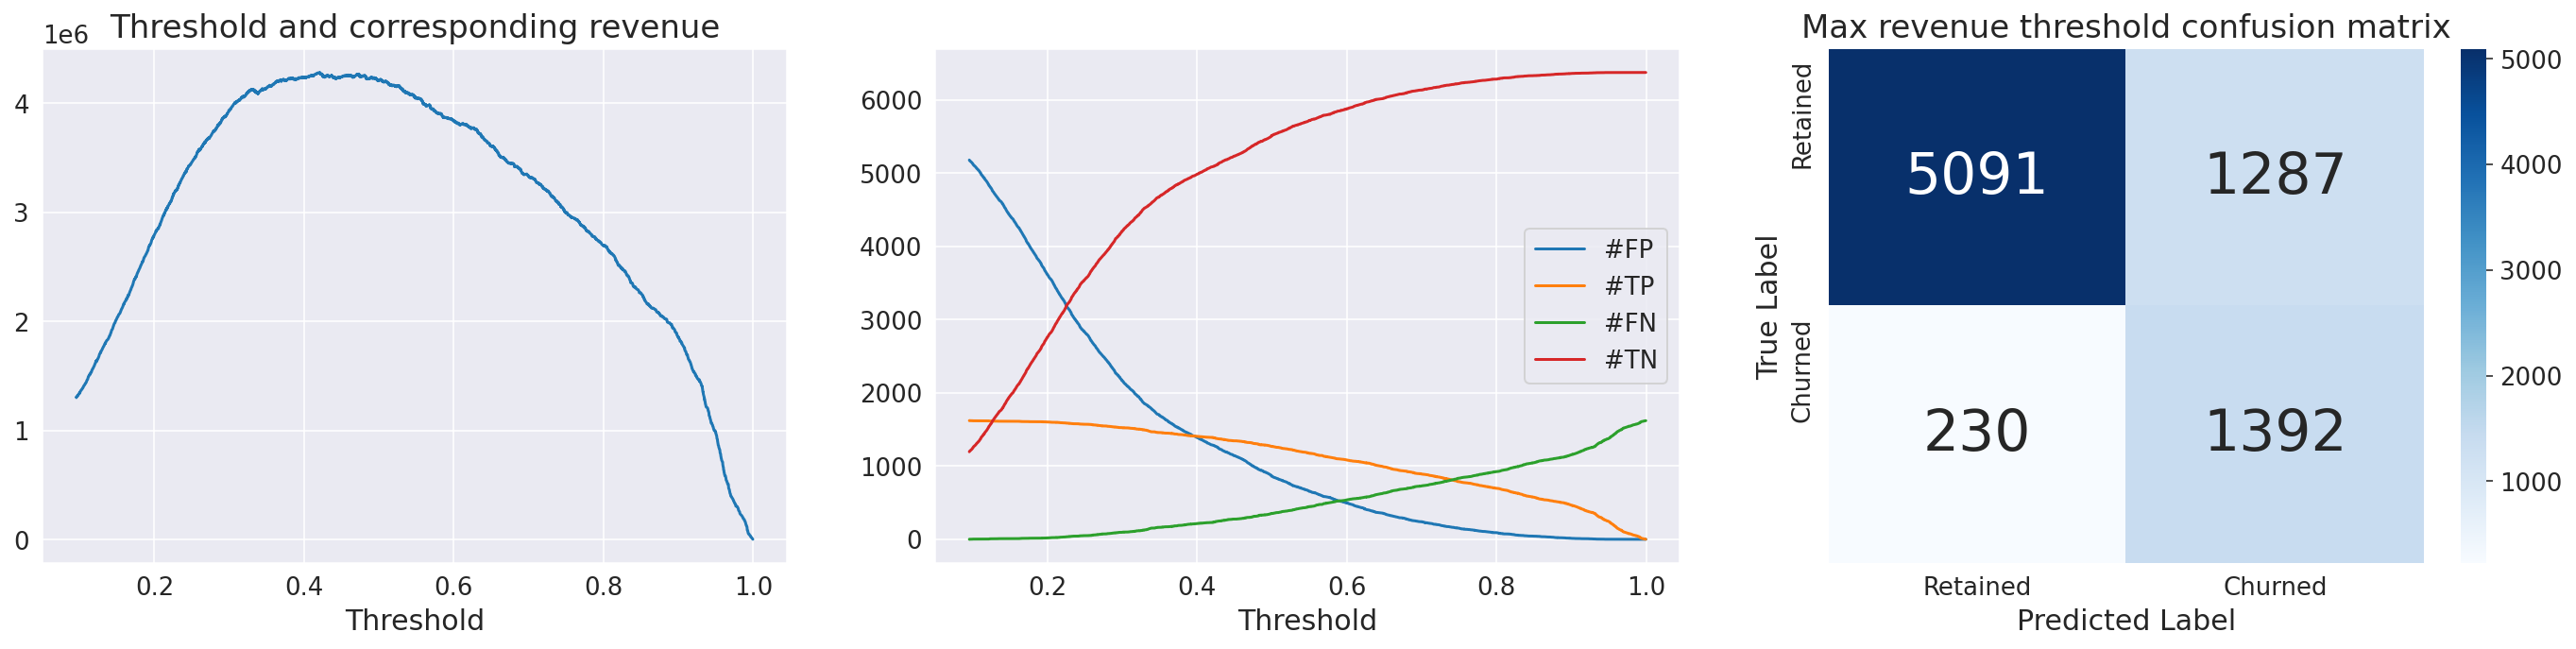

In [176]:
max_profit(n_tp,n_fp,n_tn,n_fn,customer_value=5000,retention_value=1000)

Max revenue is 1711000 and threshold 0.53


0.5275941686918002

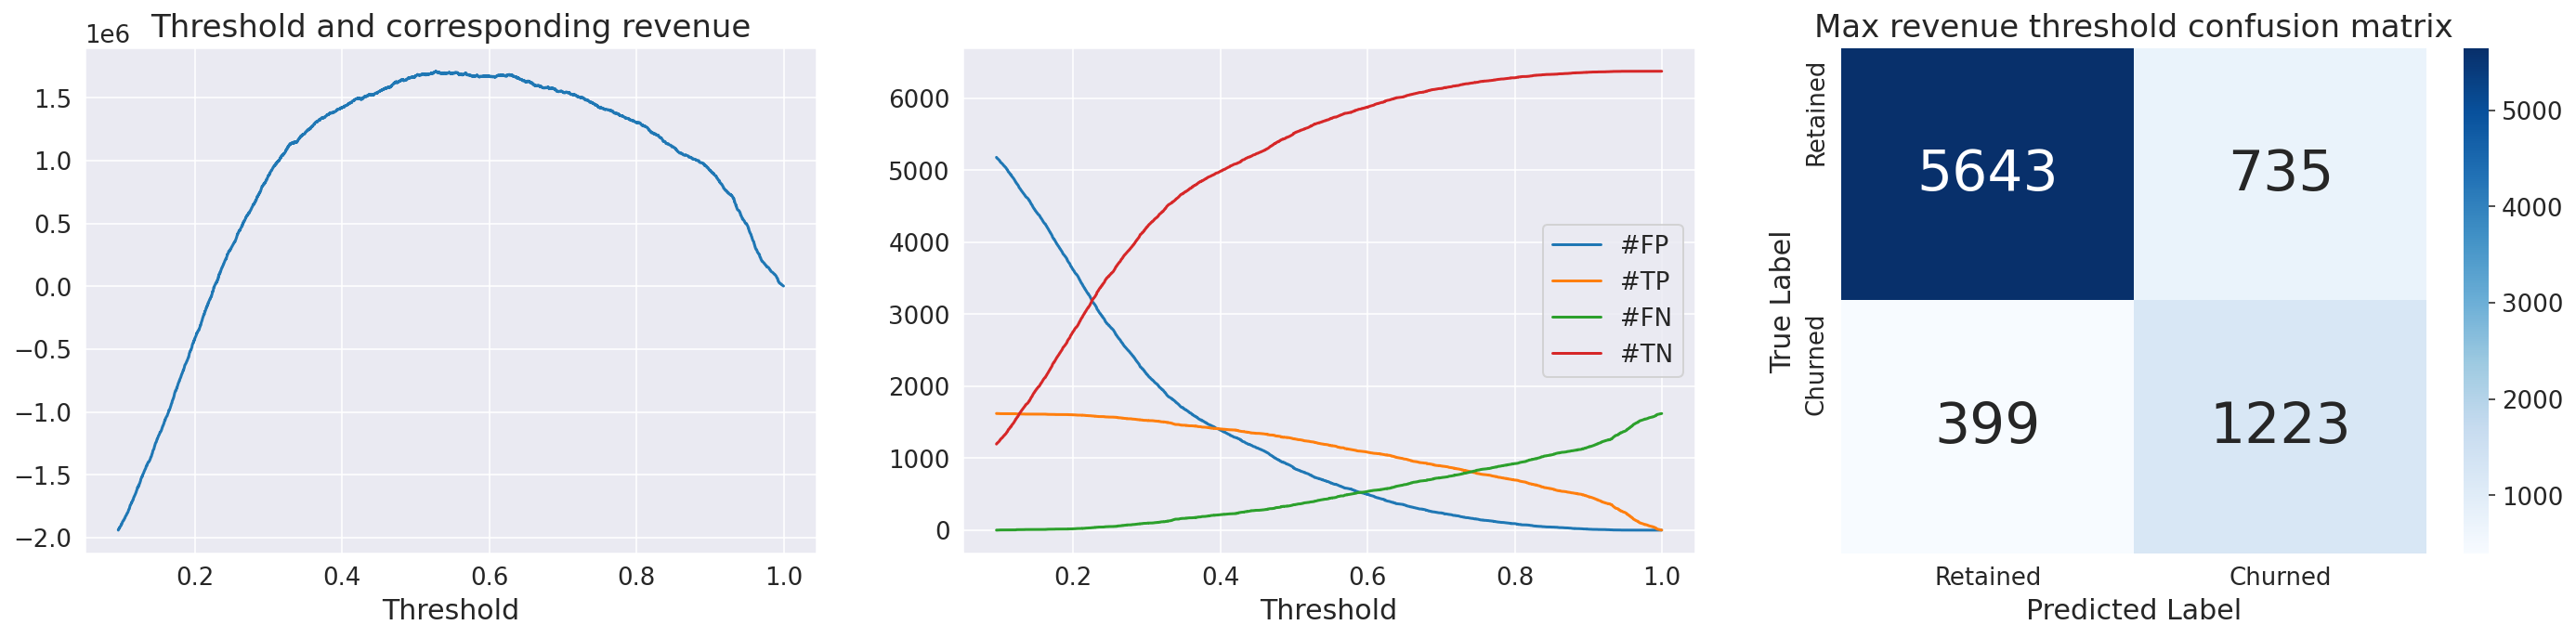

In [161]:
max_profit(n_tp,n_fp,n_tn,n_fn,customer_value=3000,retention_value=1000)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0e004c1490>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0e0052d550>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


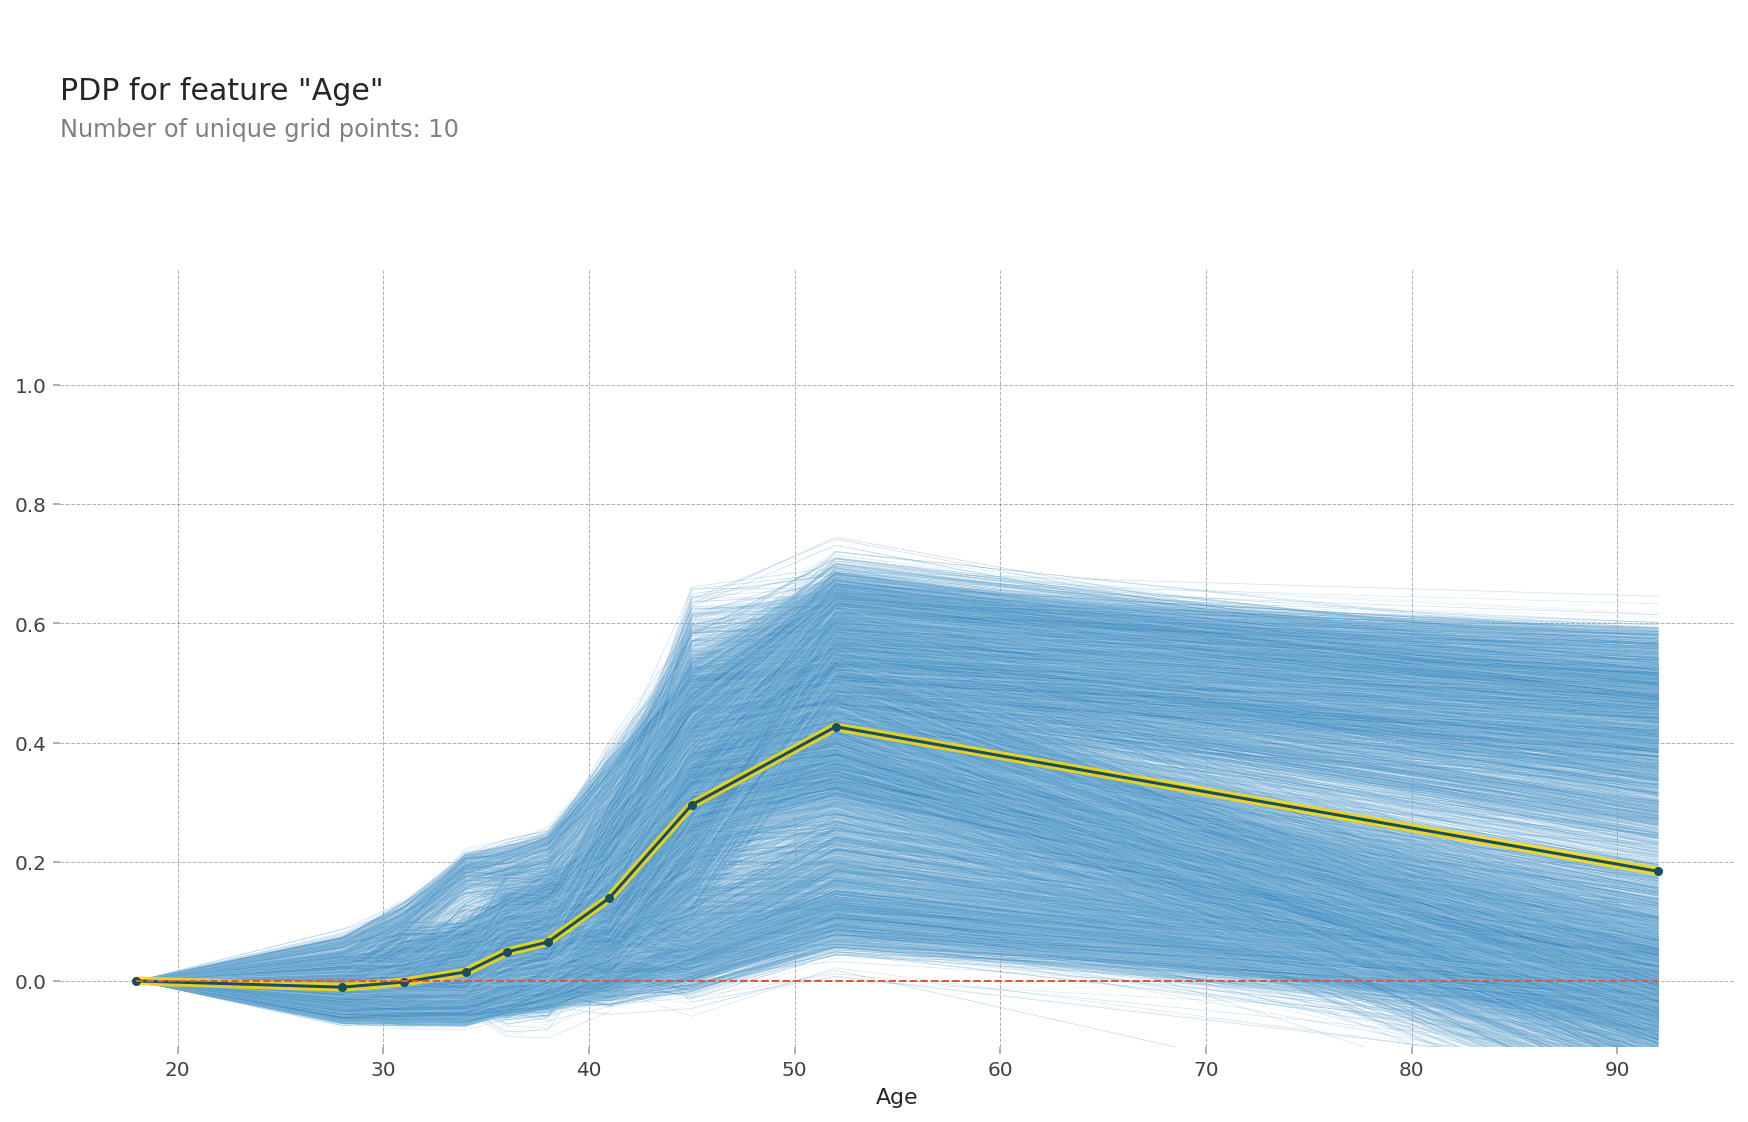

In [88]:
plot_pdp(x=train_df[feats],m=best_rf_clf, feat='Age')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0df472b6d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0df472b110>})

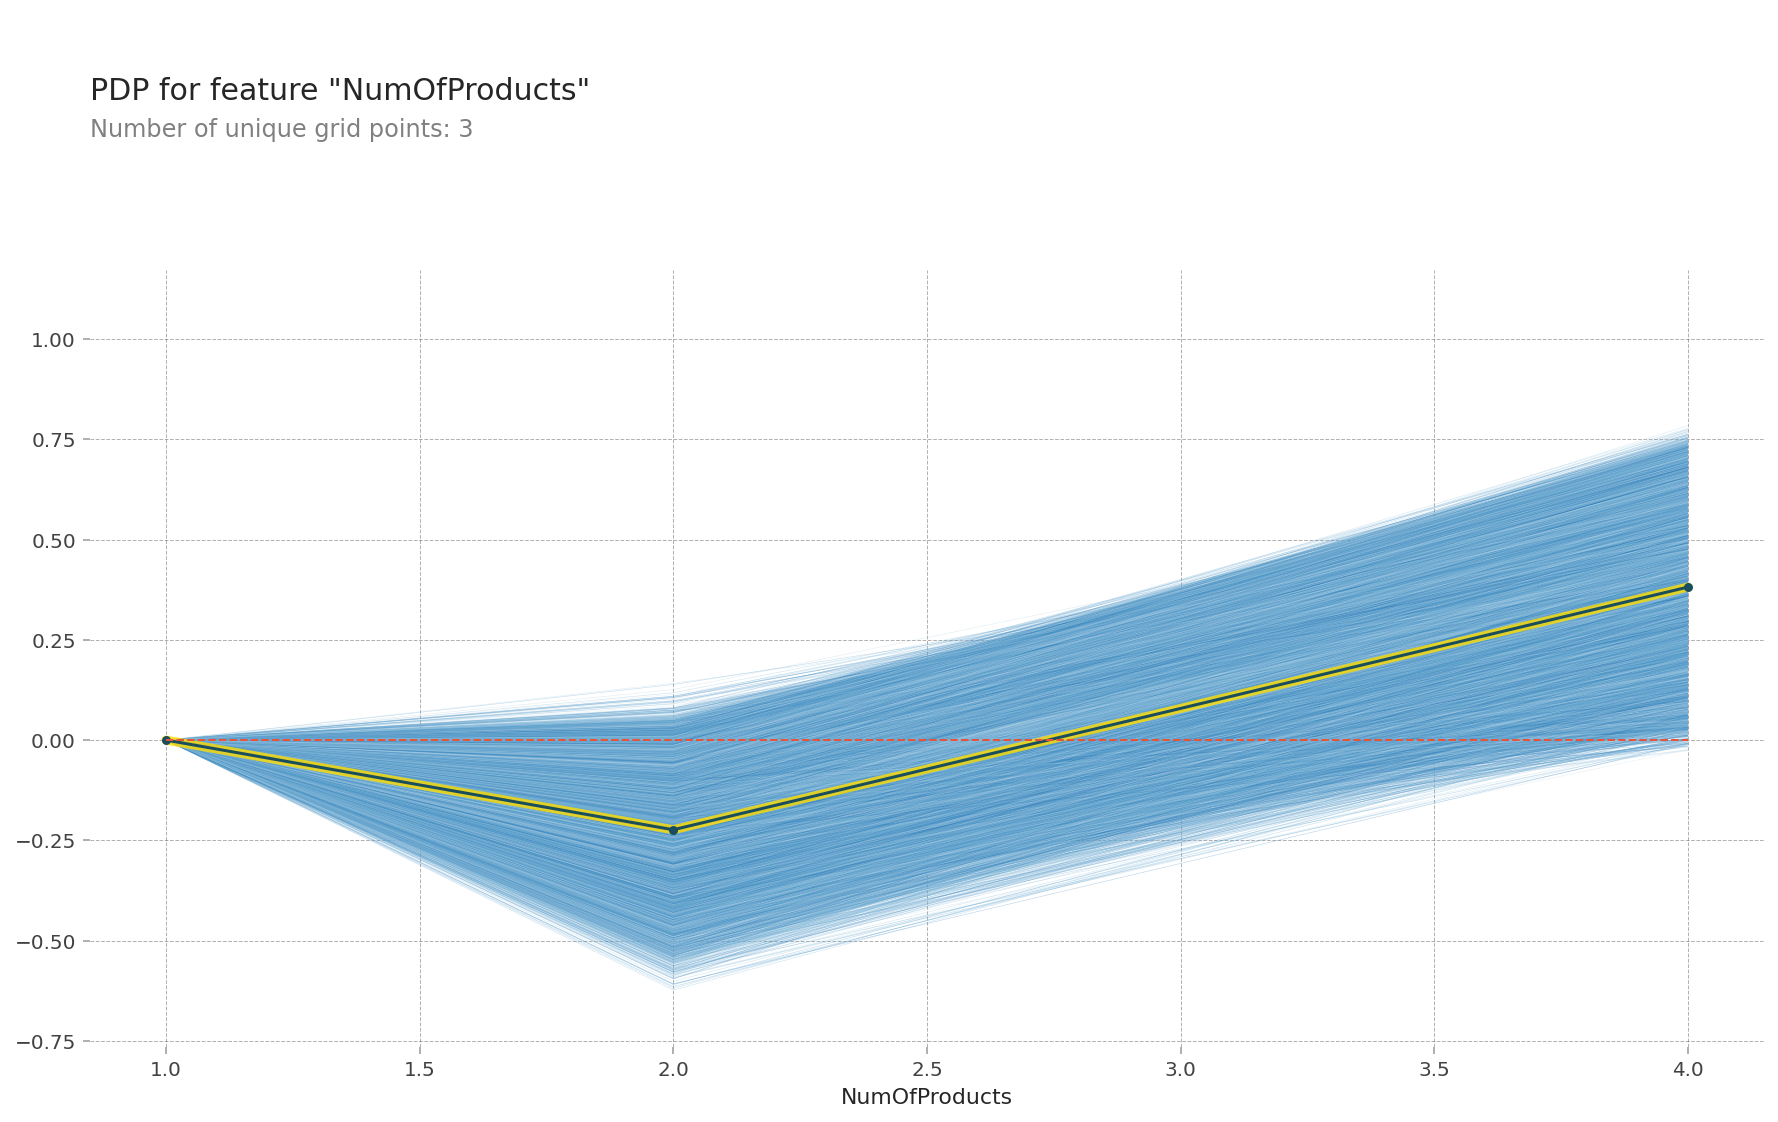

In [90]:
plot_pdp(x=train_df[feats],m=best_rf_clf, feat='NumOfProducts')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0ded19ec50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0ded1a57d0>})

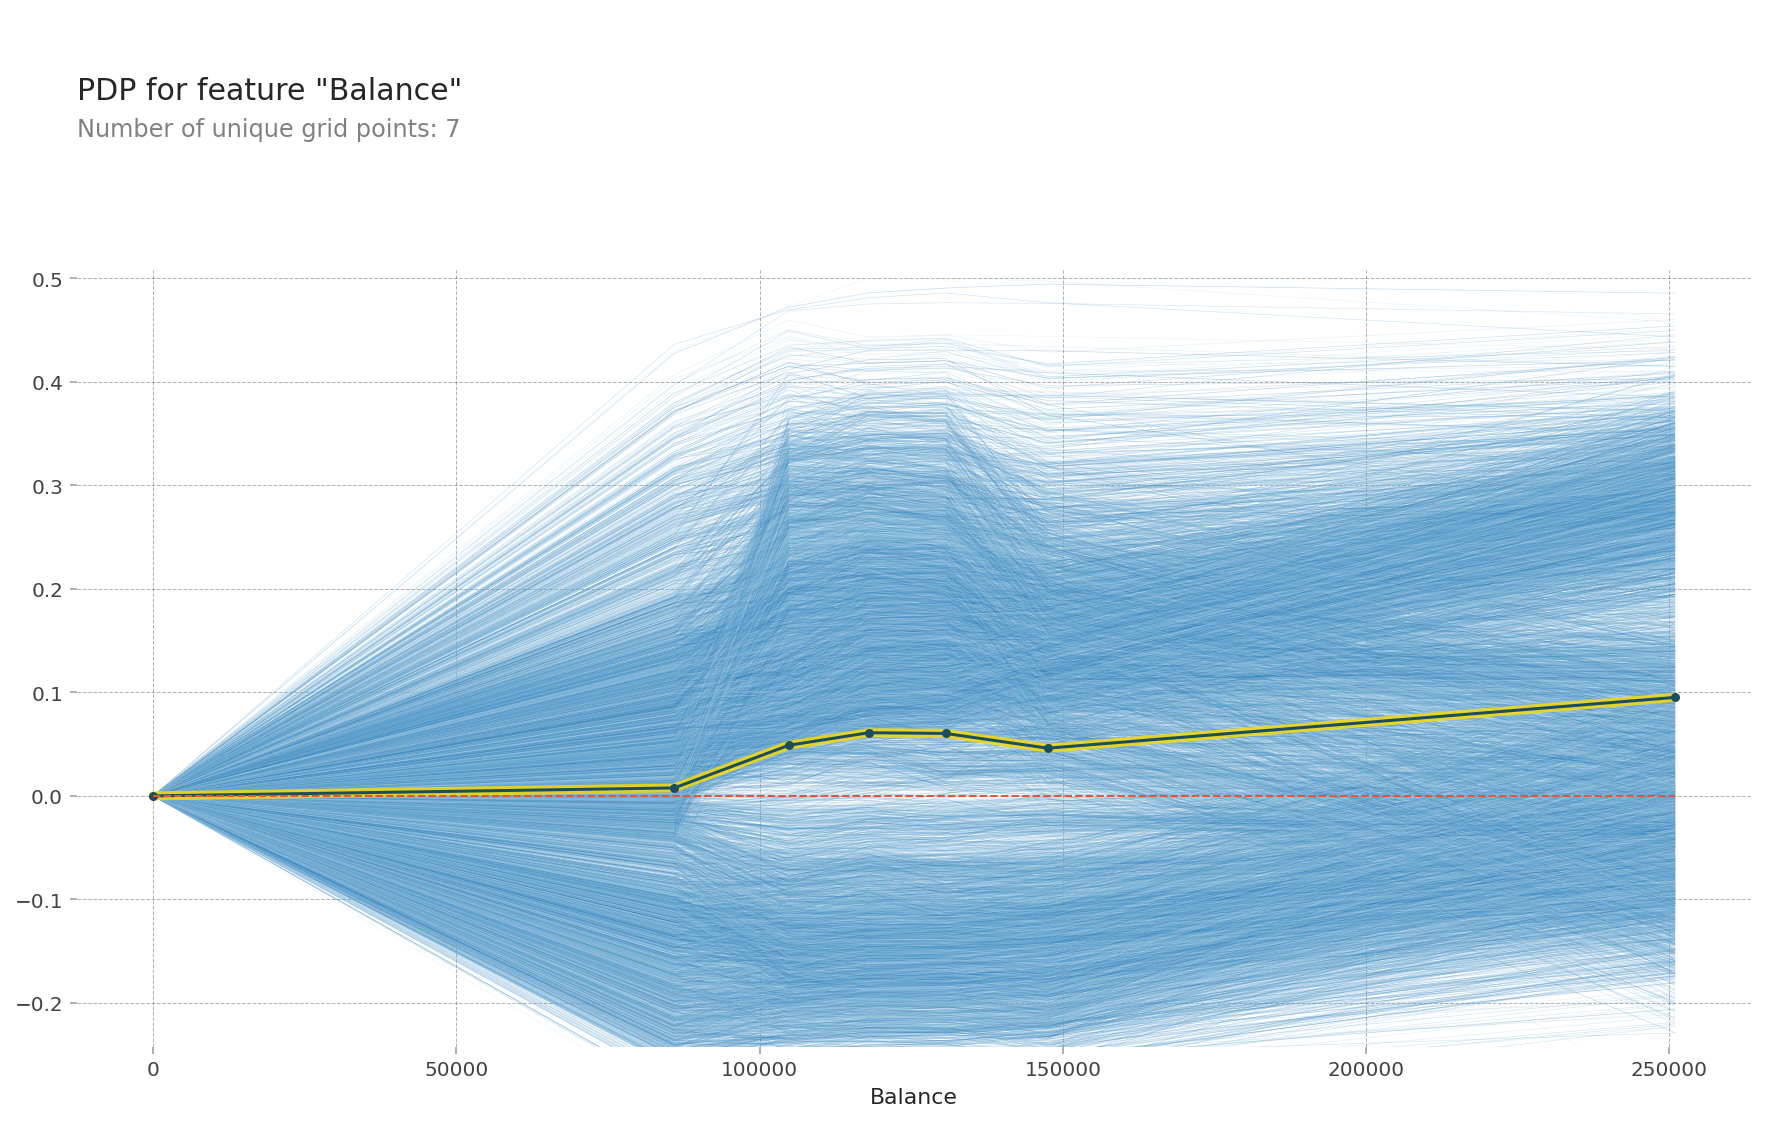

In [91]:
plot_pdp(x=train_df[feats],m=best_rf_clf, feat='Balance')

In [59]:
#### Evaluate on the test set 

In [34]:
test_df = preprocess_test(test_df,preprocess_dict)

accuracy 0.827, precision 0.5654648956356736, recall is 0.7180722891566265


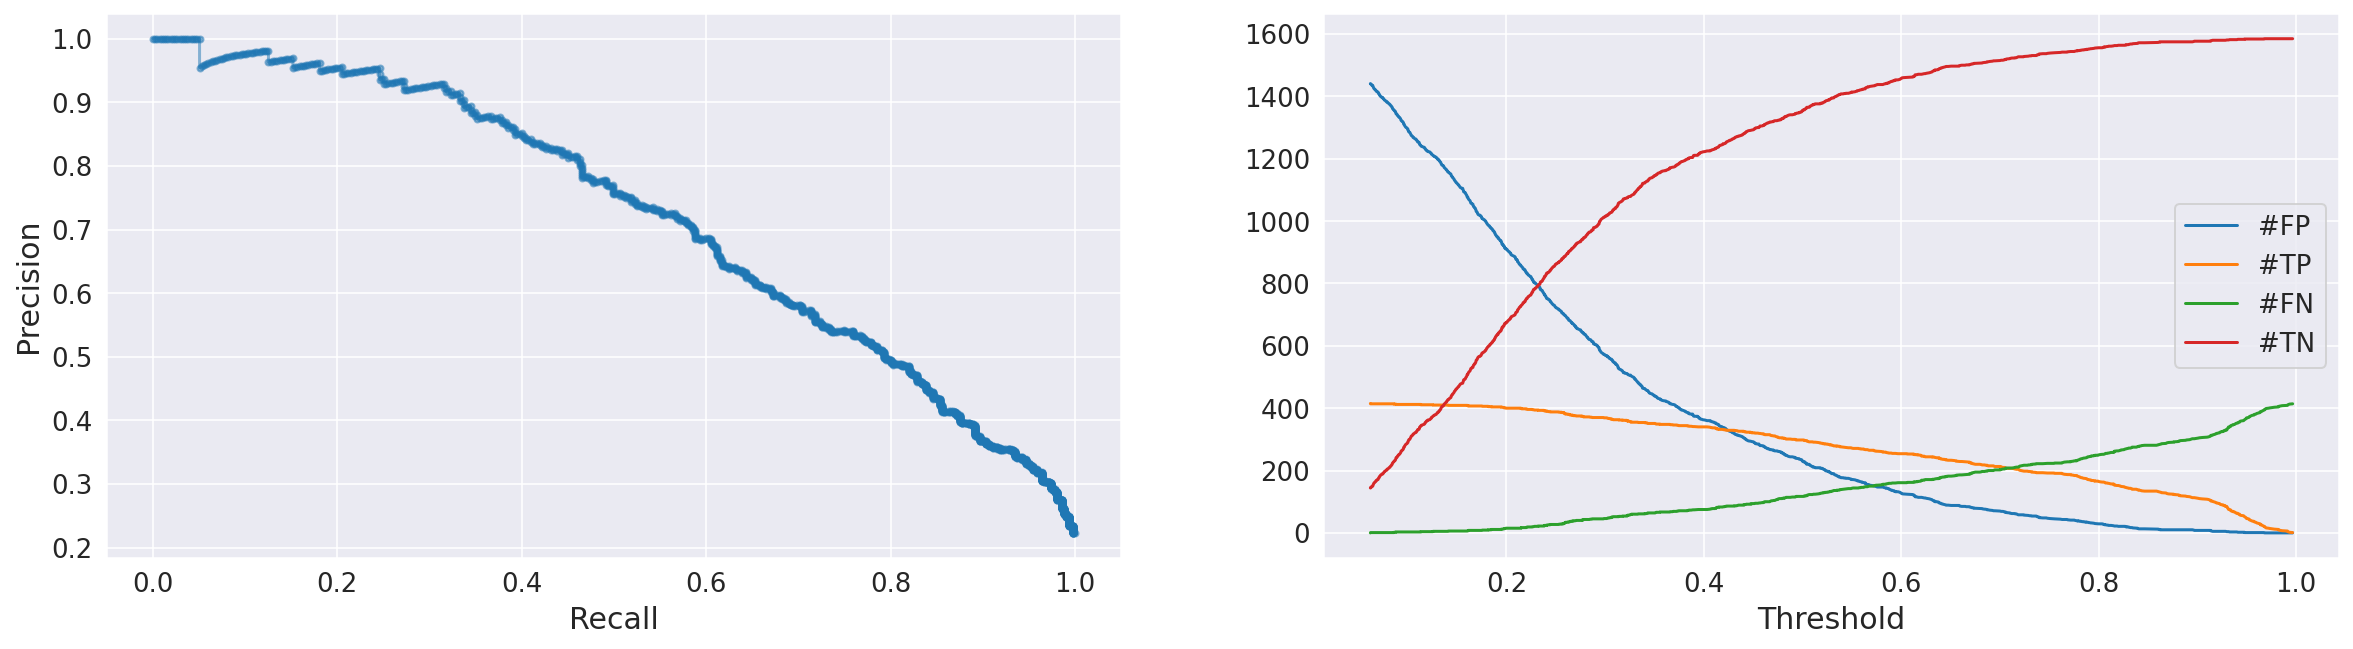

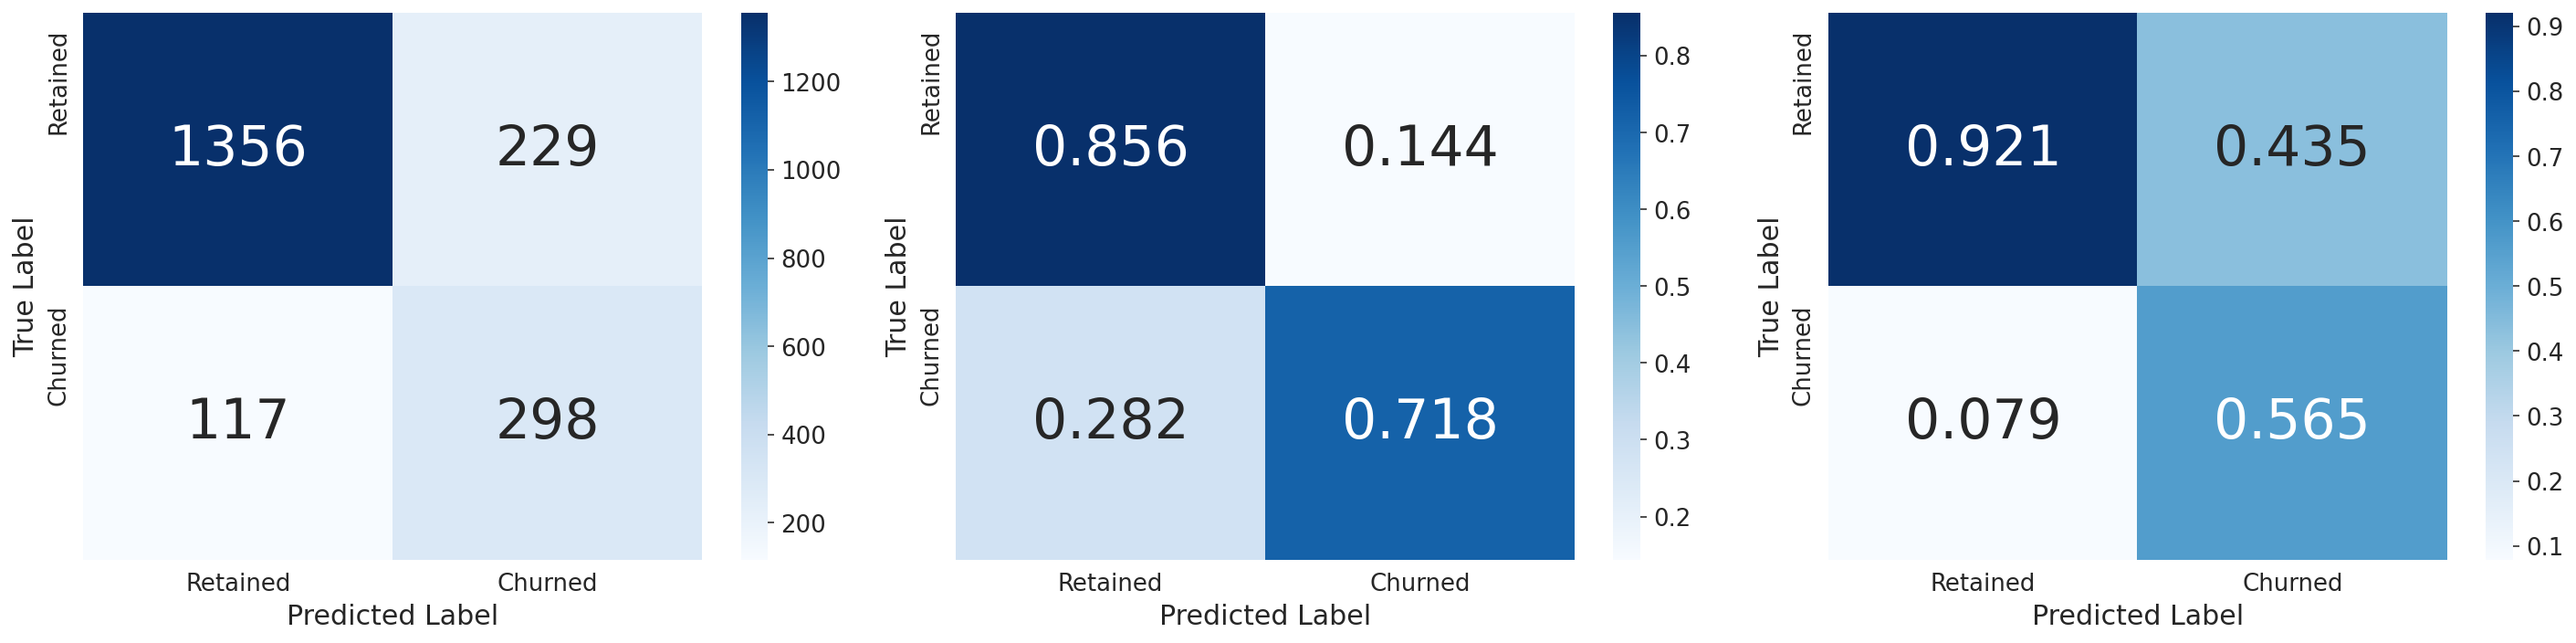

In [177]:
_ = clf_performance(test_df[feats],test_df[TARGET],best_rf_clf)

accuracy 0.79, precision 0.4962518740629685, recall is 0.7975903614457831


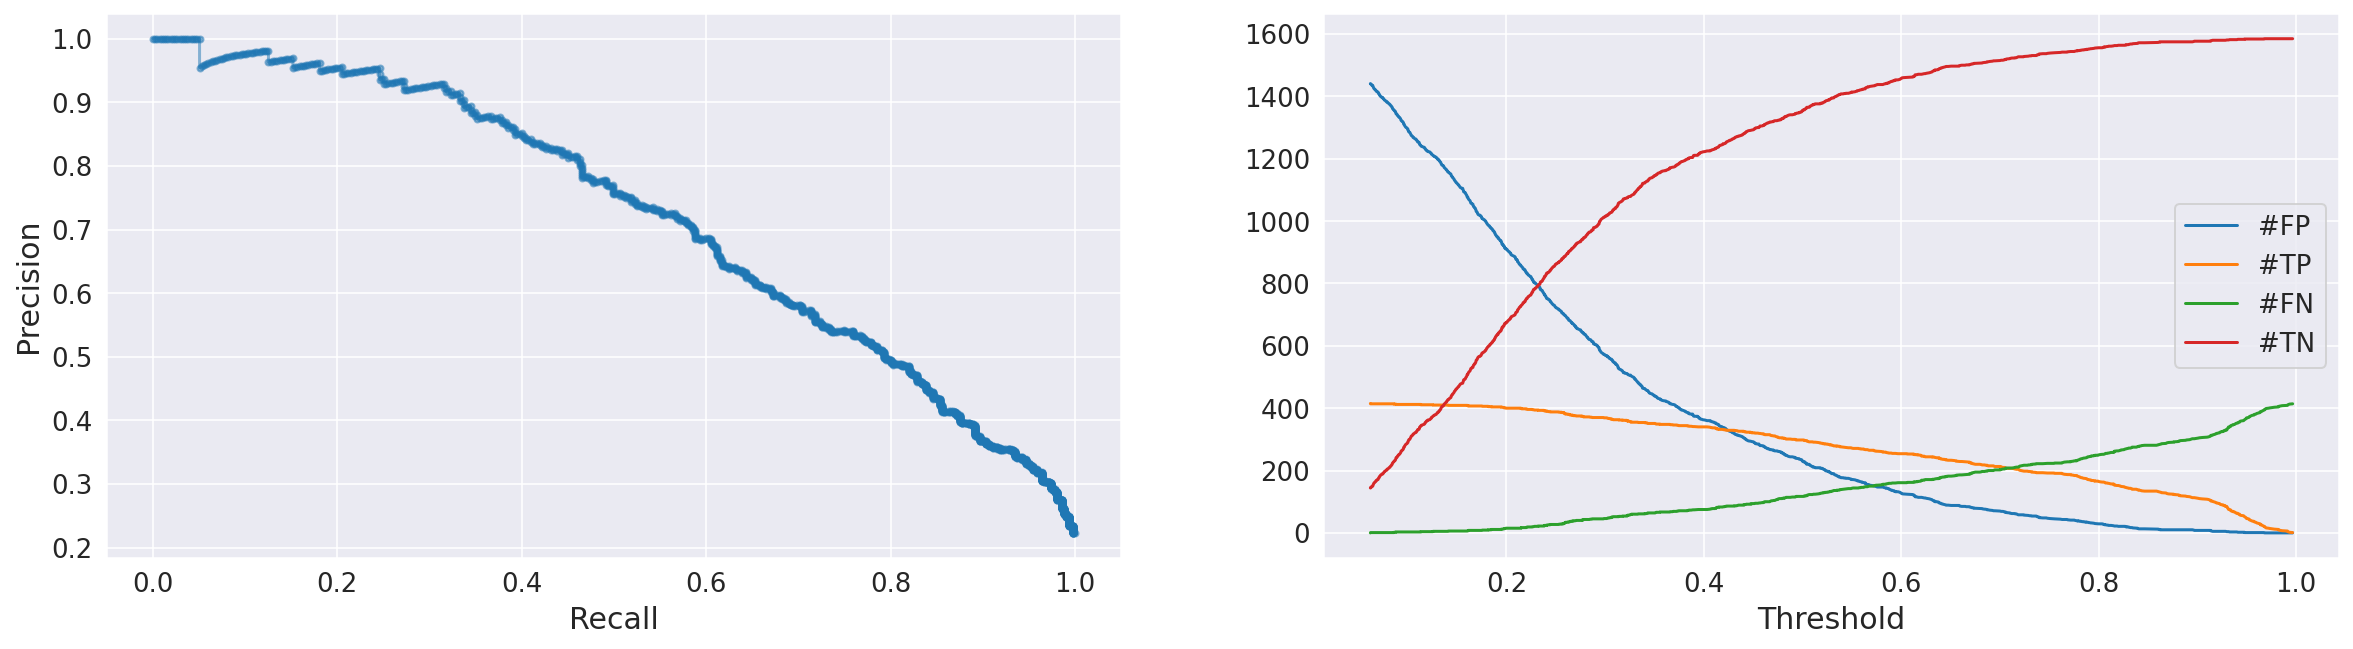

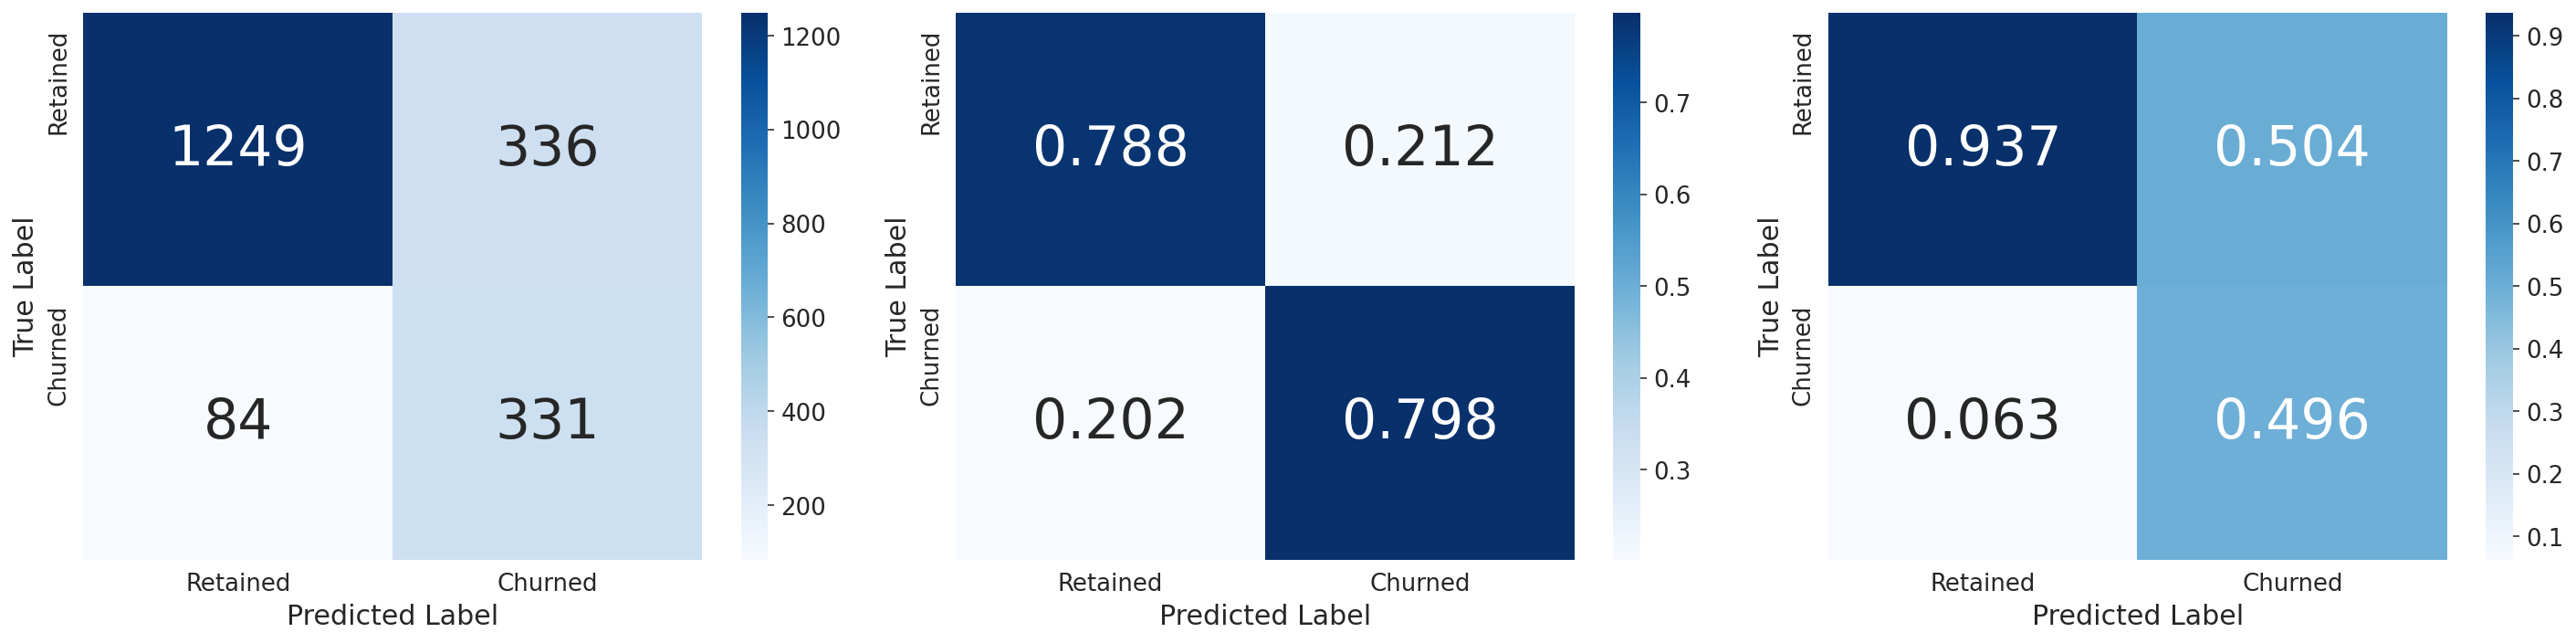

In [178]:
_ = clf_performance(test_df[feats],test_df[TARGET],best_rf_clf,cutoff=0.42)